<a id="0"></a> <br>
 # Índice de Contenidos  
1. [Importar libraries y settings](#1)     
1. [Lectura de datos y exploración inicial](#2) 
    1. [Visualización de la variable objetivo](#21)
    1. [Visualización de las variables explicativas categóricas](#22)
    1. [Visualización de las variables explicativas numéricas](#23)
1. [Preparación de las variables](#3)
    1. [Variables independientes a combinar](#31)
    1. [Estandarización de variables numéricas](#32)
    1. [Variables independientes con posibles combinaciones de respuestas](#33)
    1. [Codificación de variables independientes con una sola respuesta](#34)
    1. [Comprobación de los datos](#35)
1. [Relaciones entre variables](#4) 
    1. [Correlaciones entre variables](#41)
    1. [Relaciones entre variables con V de Cramer y Chi Cuadrado](#42)
1. [Análisis de Componentes Principales](#5)
1. [Clustering](#6)
    1. [Selección del número óptimo de clusters](#61)
    1. [Resultados del clustering con k = 4](#62)
1. [Modelos de predicción con Machine Learning](#7)
    1. [Modelos base: LinearRegression, RandomForest y XGBoost](#71)
        1. [Modelo LinearRegression](#711)
        1. [Modelo RandomForest](#712)
        1. [Modelo XGBoost](#713)
    1. [Productivizar el modelo](#72)

<a id="1"></a> 
# 1. Importar libraries y settings

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import scipy.cluster.hierarchy as sch
from scipy.spatial import distance
from scipy.stats import chi2_contingency

# Scikit-learn imports
from sklearn.preprocessing import (OrdinalEncoder, LabelBinarizer, OneHotEncoder, 
                                   StandardScaler, MinMaxScaler)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, 
                             silhouette_score, make_scorer)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import (train_test_split, GridSearchCV, learning_curve)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# XGBoost import
import xgboost as xgb

# Statsmodels import
import statsmodels.api as sm

# Other imports
from tabulate import tabulate
import joblib

# Adjust the display setting to show all columns
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

/var/folders/dm/xc68z2ls0d5gs2zbxxn7vn680000gn/T/ipykernel_4380/1844470503.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 111999

<a id="2"></a> 
# 2. Lectura de datos y exploración inicial

In [3]:
# Definimos la ruta del archivo CSV que contiene los datos y cargamos el archivo CSV en un DataFrame de pandas.
file_path = '/Users/maria/Desktop/MASTER_DATA_SCIENCE/TFM/Carbon_Emission.csv'

datos_load = pd.read_csv(file_path) 
datos = datos_load
display(datos.head())

# Mostramos la información general del DataFrame, incluyendo el tipo de cada variable para verificar el formato y tipo de datos que se ha asignado en la lectura.
display(datos.info())

Body Type     Sex         Diet How Often Shower Heating Energy Source  \
0  overweight  female  pescatarian            daily                  coal   
1       obese  female   vegetarian  less frequently           natural gas   
2  overweight    male     omnivore  more frequently                  wood   
3  overweight    male     omnivore      twice a day                  wood   
4       obese  female   vegetarian            daily                  coal   

      Transport Vehicle Type Social Activity  Monthly Grocery Bill  \
0        public          NaN           often                   230   
1  walk/bicycle          NaN           often                   114   
2       private       petrol           never                   138   
3  walk/bicycle          NaN       sometimes                   157   
4       private       diesel           often                   266   

  Frequency of Traveling by Air  Vehicle Monthly Distance Km Waste Bag Size  \
0                    frequently                          210          large   
1                        rarely                            9    extra large   
2                         never                         2472          small   
3                        rarely                           74         medium   
4               very frequently                         8457          large   

   Waste Bag Weekly Count  How Long TV PC Daily Hour  \
0                       4                          7   
1                       3                          9   
2                       1                         14   
3                       3                         20   
4                       1                          3   

   How Many New Clothes Monthly  How Long Internet Daily Hour  \
0                            26                             1   
1                            38                             5   
2                            47                             6   
3                             5                             7   
4                             5                             6   

  Energy efficiency                               Recycling  \
0                No                               ['Metal']   
1                No                               ['Metal']   
2         Sometimes                               ['Metal']   
3         Sometimes  ['Paper', 'Plastic', 'Glass', 'Metal']   
4               Yes                               ['Paper']   

                         Cooking_With  CarbonEmission  
0                   ['Stove', 'Oven']            2238  
1              ['Stove', 'Microwave']            1892  
2               ['Oven', 'Microwave']            2595  
3  ['Microwave', 'Grill', 'Airfryer']            1074  
4                            ['Oven']            4743

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null  int64 
 13  Ho

None

In [4]:
# Renombramos columnas específicas del DataFrame para que los nombres sean más claros y consistentes.
datos = datos.rename(columns={'Body Type': 'BodyType', 
                              'How Often Shower': 'ShowerFreq',
                              'Heating Energy Source': 'EnergyHeat',
                              'Vehicle Type': 'VehicleType',
                              'Social Activity': 'SocialActivity',
                              'Monthly Grocery Bill': 'GroceryBill',
                              'Frequency of Traveling by Air': 'AirTravelFreq',
                              'Vehicle Monthly Distance Km': 'DriveDistance',
                              'Waste Bag Size': 'WasteBagSize',
                              'Waste Bag Weekly Count': 'WasteBagCount',
                              'How Long TV PC Daily Hour': 'TVPCHours',
                              'How Many New Clothes Monthly': 'ClothesNew',
                              'How Long Internet Daily Hour': 'InternetHours',
                              'Energy efficiency': 'EnergyEfficiency'
                              })

In [5]:
datos.head()

BodyType     Sex         Diet       ShowerFreq   EnergyHeat  \
0  overweight  female  pescatarian            daily         coal   
1       obese  female   vegetarian  less frequently  natural gas   
2  overweight    male     omnivore  more frequently         wood   
3  overweight    male     omnivore      twice a day         wood   
4       obese  female   vegetarian            daily         coal   

      Transport VehicleType SocialActivity  GroceryBill    AirTravelFreq  \
0        public         NaN          often          230       frequently   
1  walk/bicycle         NaN          often          114           rarely   
2       private      petrol          never          138            never   
3  walk/bicycle         NaN      sometimes          157           rarely   
4       private      diesel          often          266  very frequently   

   DriveDistance WasteBagSize  WasteBagCount  TVPCHours  ClothesNew  \
0            210        large              4          7          26   
1              9  extra large              3          9          38   
2           2472        small              1         14          47   
3             74       medium              3         20           5   
4           8457        large              1          3           5   

   InternetHours EnergyEfficiency                               Recycling  \
0              1               No                               ['Metal']   
1              5               No                               ['Metal']   
2              6        Sometimes                               ['Metal']   
3              7        Sometimes  ['Paper', 'Plastic', 'Glass', 'Metal']   
4              6              Yes                               ['Paper']   

                         Cooking_With  CarbonEmission  
0                   ['Stove', 'Oven']            2238  
1              ['Stove', 'Microwave']            1892  
2               ['Oven', 'Microwave']            2595  
3  ['Microwave', 'Grill', 'Airfryer']            1074  
4                            ['Oven']            4743

In [6]:
# Genera una lista con los nombres de las variables
variables = list(datos.columns)

# Definimos la variable objetivo 'CarbonEmission' para la predicción y creamos una lista de variables explicativas
VarObj = ['CarbonEmission']
VarExp = [var for var in variables if var != 'CarbonEmission']

# Seleccionamos las columnas numéricas del DataFrame
numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns
numericas = numericas[numericas != 'CarbonEmission']

# Seleccionamos las columnas categóricas del DataFrame
categoricas = [variable for variable in VarExp if variable not in numericas]

In [7]:
# Reemplazamos los valores NaN en la columna 'VehicleType' con el string 'NaN'.
# Esto permite tratar los valores faltantes como una categoría específica en lugar de un valor nulo.
datos['VehicleType'] = datos['VehicleType'].fillna('NaN')

<a id="21"></a> 
## 2.1 Visualización de la variable objetivo

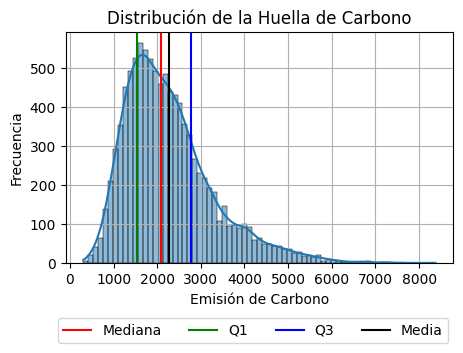

In [8]:
# Creamos una figura y un eje para el histograma
fig, axes = plt.subplots(1,1, figsize=(5, 3))

# Creamos un histograma de la columna 'CarbonEmission' con una estimación de densidad (kde).
sns.histplot(x='CarbonEmission', data=datos, kde=True, ax=axes)
axes.set_title(f'Distribution of CarbonEmission')
axes.set_xlabel('')
axes.set_ylabel('Density')

# Calculamos estadísticas descriptivas para la columna 'CarbonEmission' y aregamos líneas verticales para las estadísticas calculadas en el histograma
med = datos_load['CarbonEmission'].median()
ave = datos_load['CarbonEmission'].mean()
q1 = datos_load['CarbonEmission'].quantile(0.25)
q3 = datos_load['CarbonEmission'].quantile(0.75)
axes.axvline(med, color='r', linestyle='-', label=f'Mediana')
axes.axvline(q1, color='g', linestyle='-', label=f'Q1')
axes.axvline(q3, color='b', linestyle='-', label=f'Q3')
axes.axvline(ave, color='k', linestyle='-', label=f'Media')

# Configuramos el gráfico
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.title('Distribución de la Huella de Carbono')
plt.xlabel('Emisión de Carbono')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

<a id="22"></a> 
## 2.2 Visualización de las variables explicativas categóricas

In [9]:
# Identificamos las columnas categóricas en el DataFrame
categorical_columns = datos.select_dtypes(include=['object']).columns

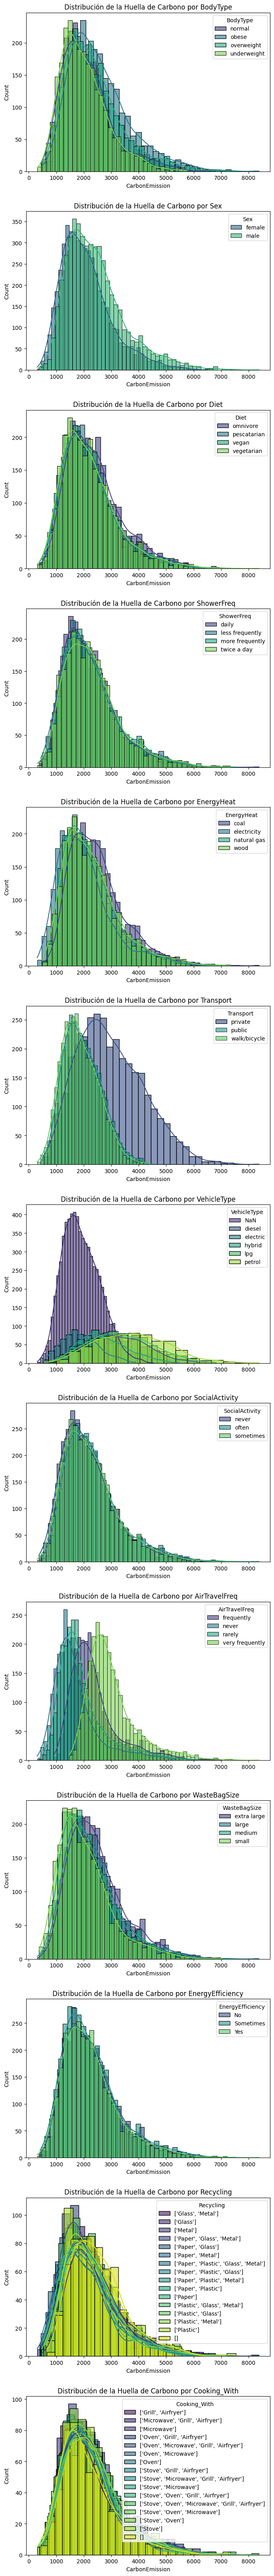

In [10]:
# Primero se investiga la distribución de la variable objetivo en relación a las categorías de cada variable categórica

# Configuramos el número de subplots, uno para cada variable categórica
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(7, 5 * len(categorical_columns)))

# Iteramos sobre cada variable categórica para crear un histograma
for idx, column in enumerate(categorical_columns):
    # Calculamos la media de 'CarbonEmission' para cada categoría de la variable categórica.
    mean_emission = datos.groupby(column)['CarbonEmission'].mean()
    unique_values = mean_emission.index
    
    # Configuramos el gráfico
    palette = sns.color_palette("viridis", len(unique_values))
    ax = axes[idx]
    for i, value in enumerate(unique_values):
        subset_df = datos[datos[column] == value]
        # Creamos un histograma con densidad (kde) para la categoría actual
        sns.histplot(data=subset_df, x="CarbonEmission", color=palette[i], kde=True, label=value, alpha=0.6, ax=ax)
    
    ax.set_title(f"Distribución de la Huella de Carbono por {column}")
    ax.legend(title=column)
    
plt.tight_layout()
plt.show()


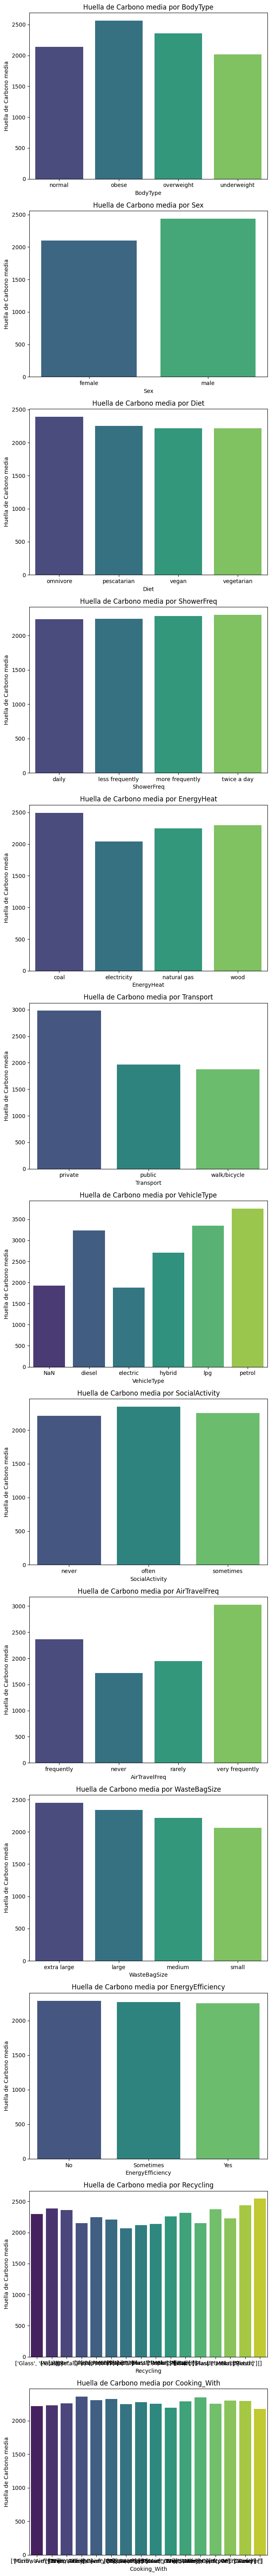

In [11]:
# A continuación, se investiga la media de la variable objetivo en relación a las categorías de cada variable categórica

# Crear los subplots, uno para cada variable categórica.
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(7, 5 * len(categorical_columns)))

# Iteramos sobre cada variable categórica para crear un gráfico de barras
for idx, column in enumerate(categorical_columns):
    ax = axes[idx]
    
    # Calculamos la media de 'CarbonEmission' para cada categoría de la variable categórica
    mean_emission = datos.groupby(column)['CarbonEmission'].mean()
    
    # Configuramos el gráfico
    sns.barplot(x=mean_emission.index, y=mean_emission.values, ax=ax, palette="viridis")
    ax.set_title(f"Huella de Carbono media por {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Huella de Carbono media")

plt.tight_layout()
plt.show()

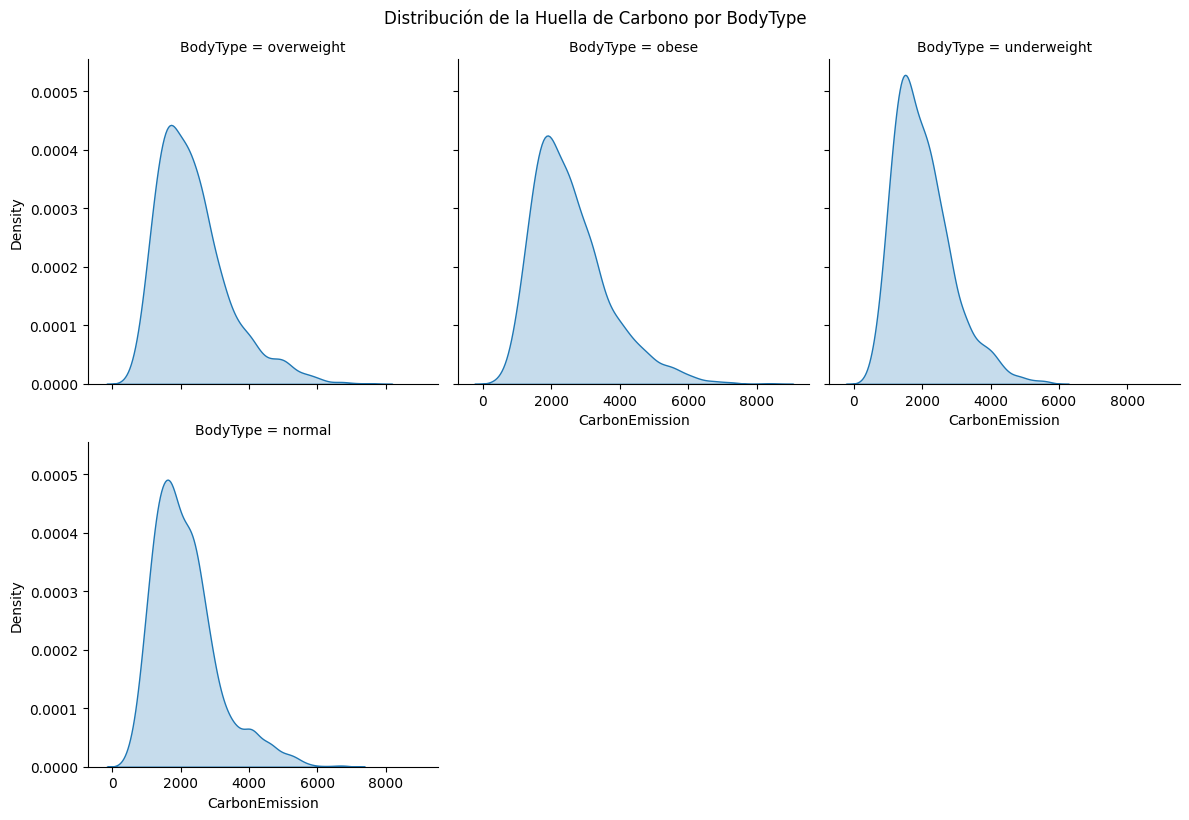

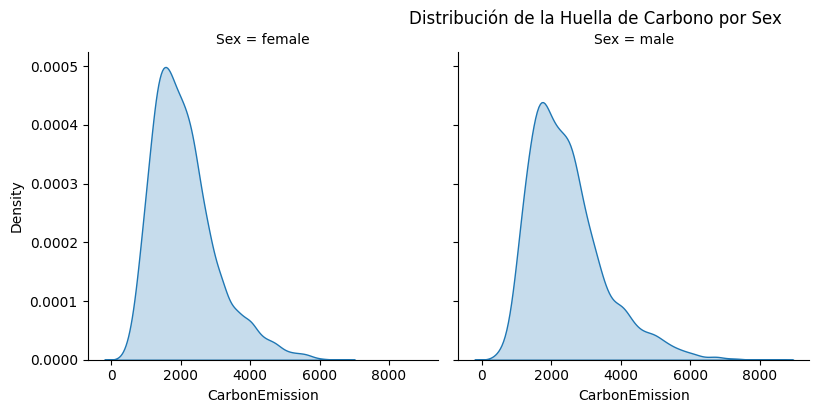

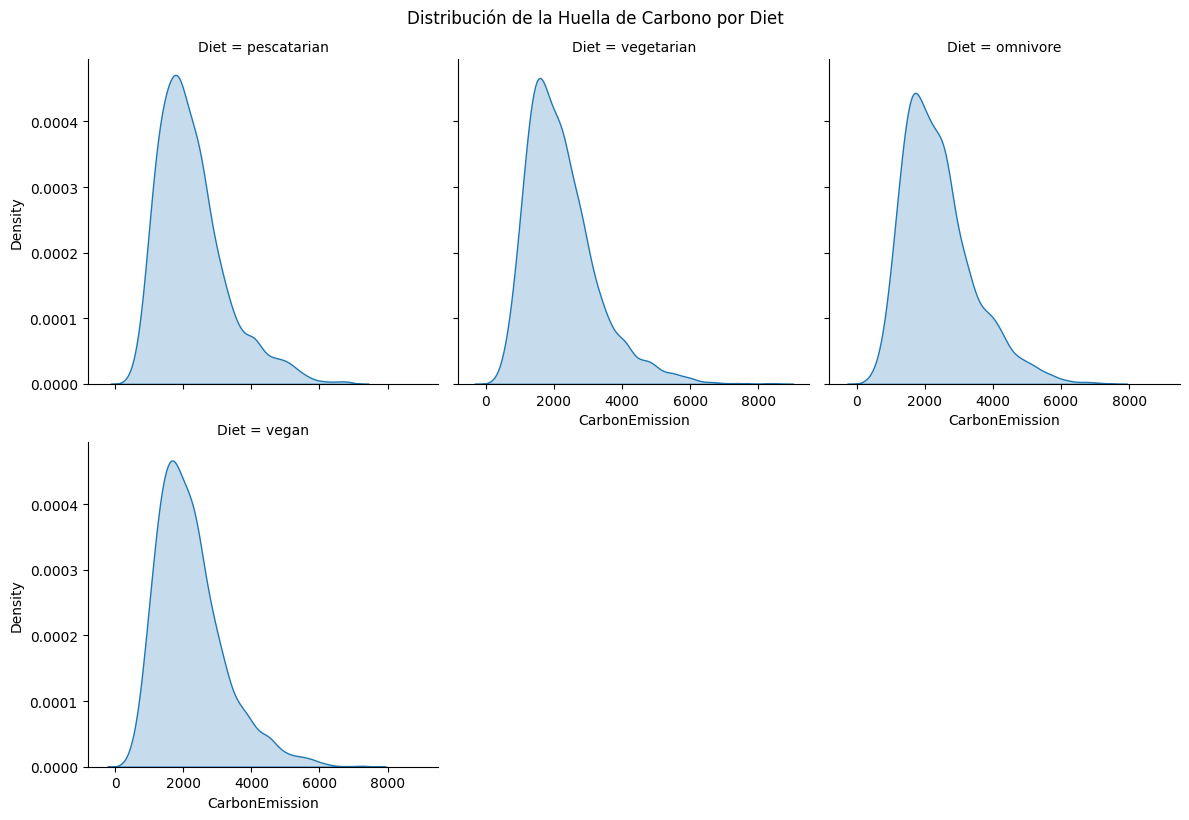

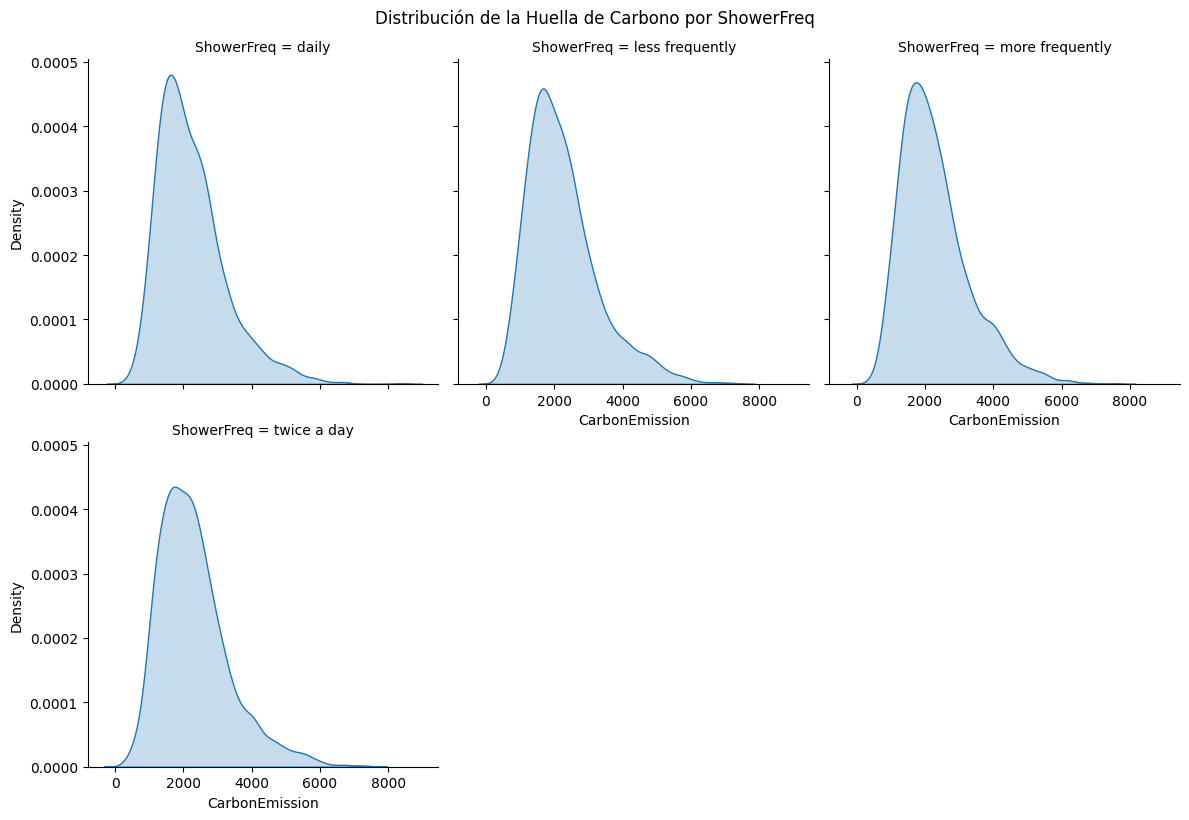

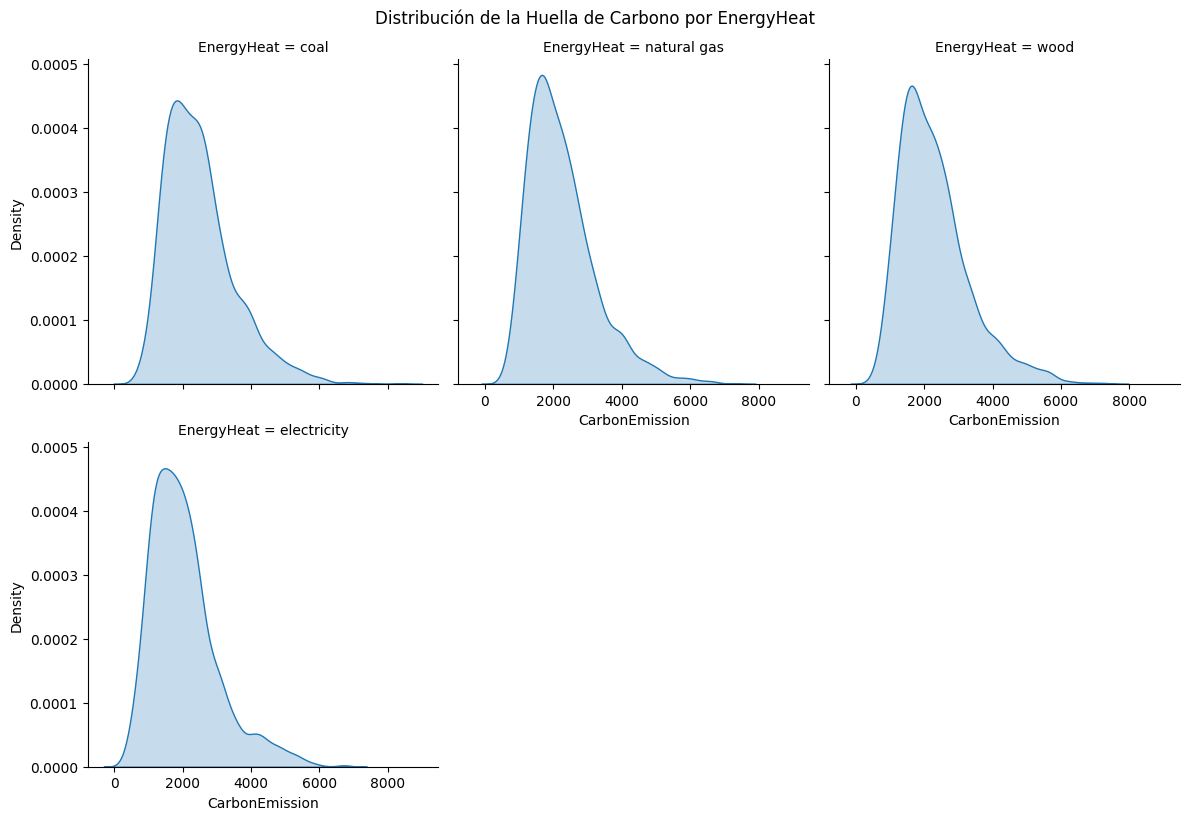

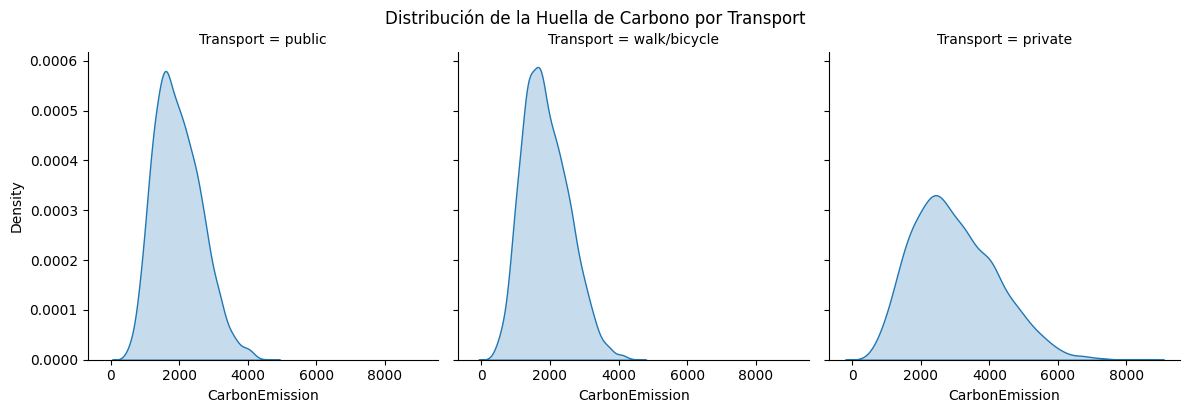

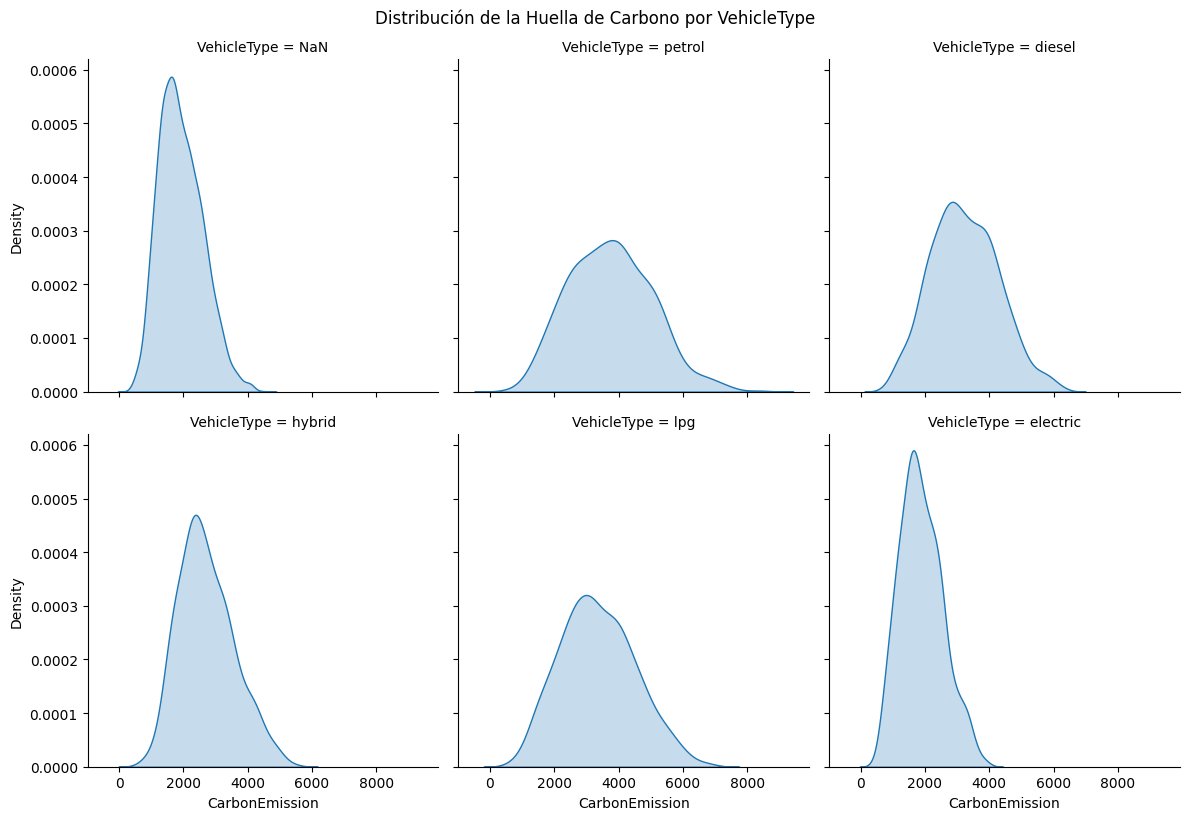

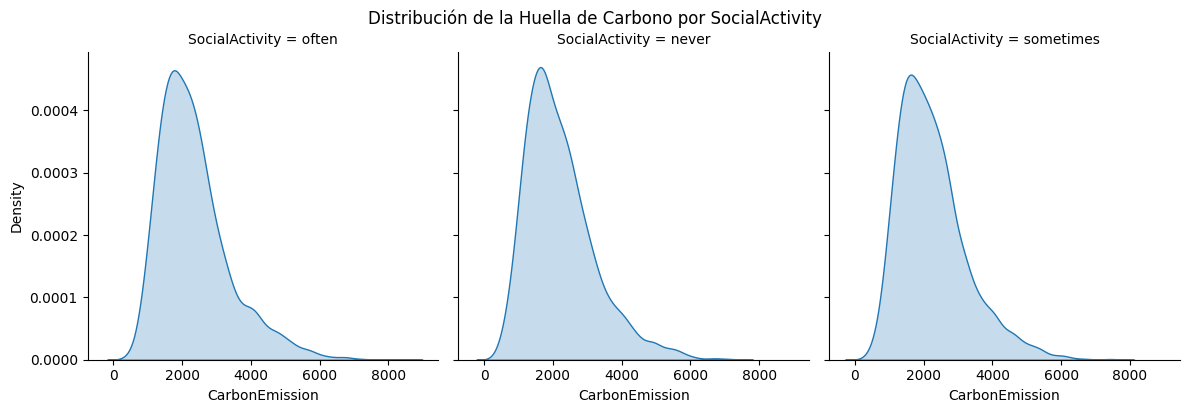

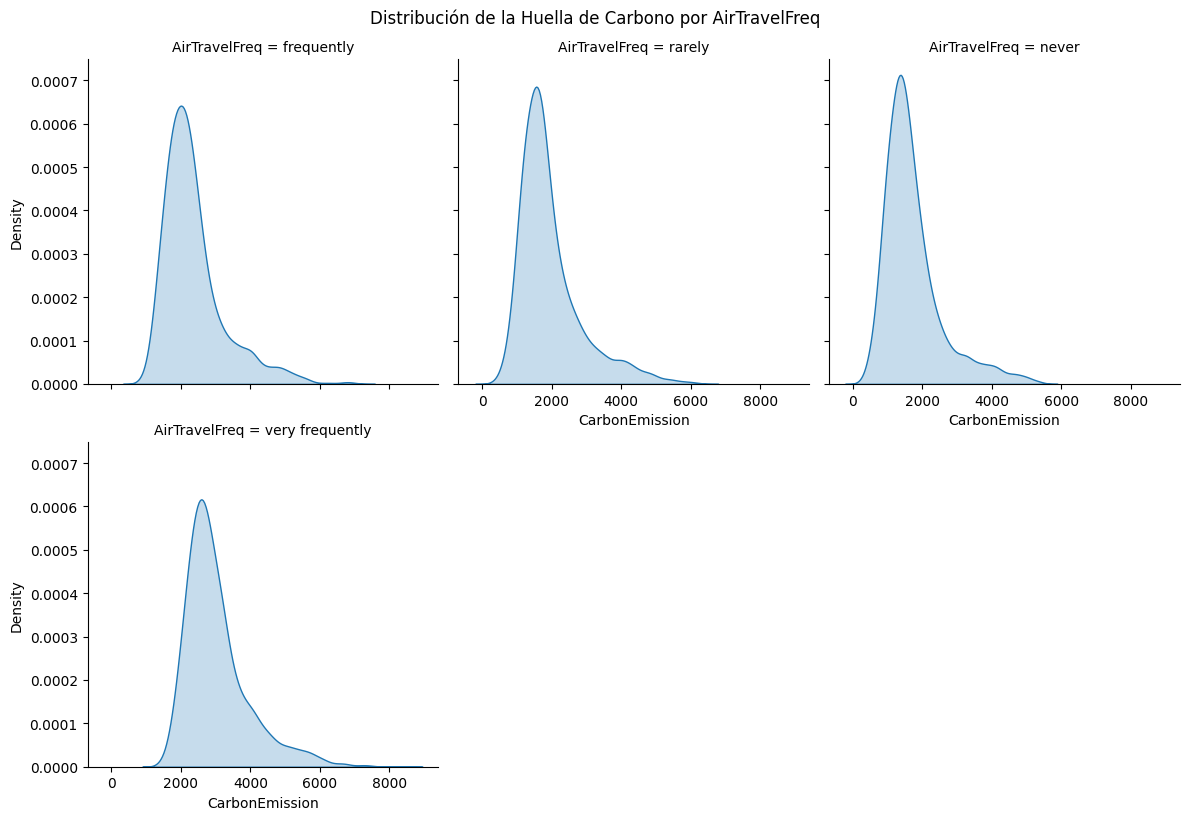

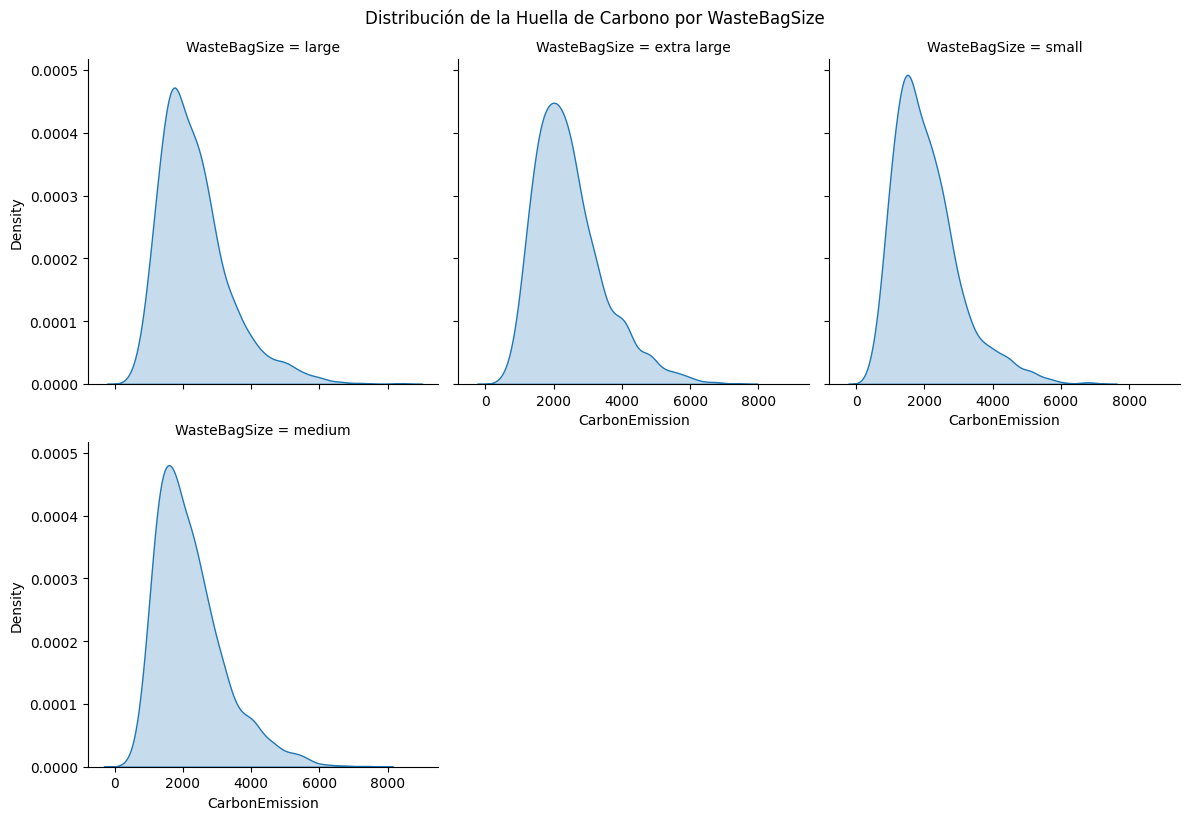

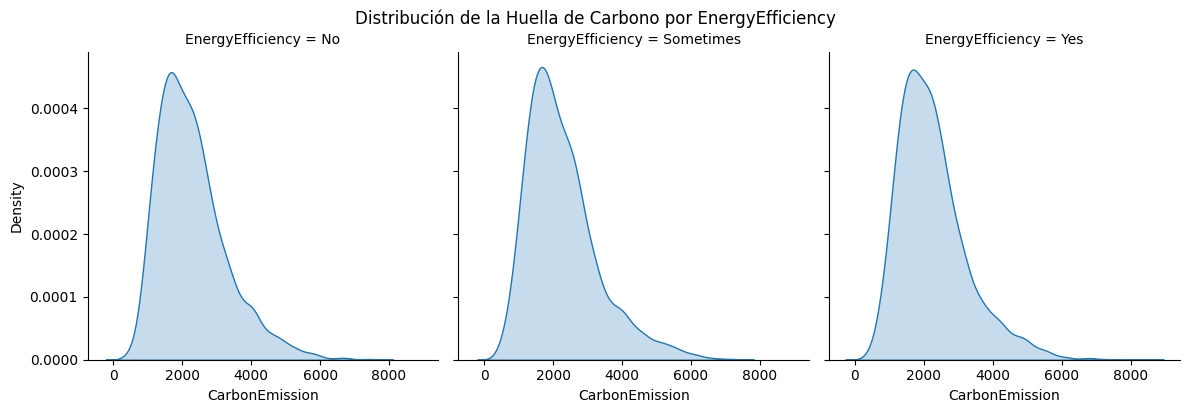

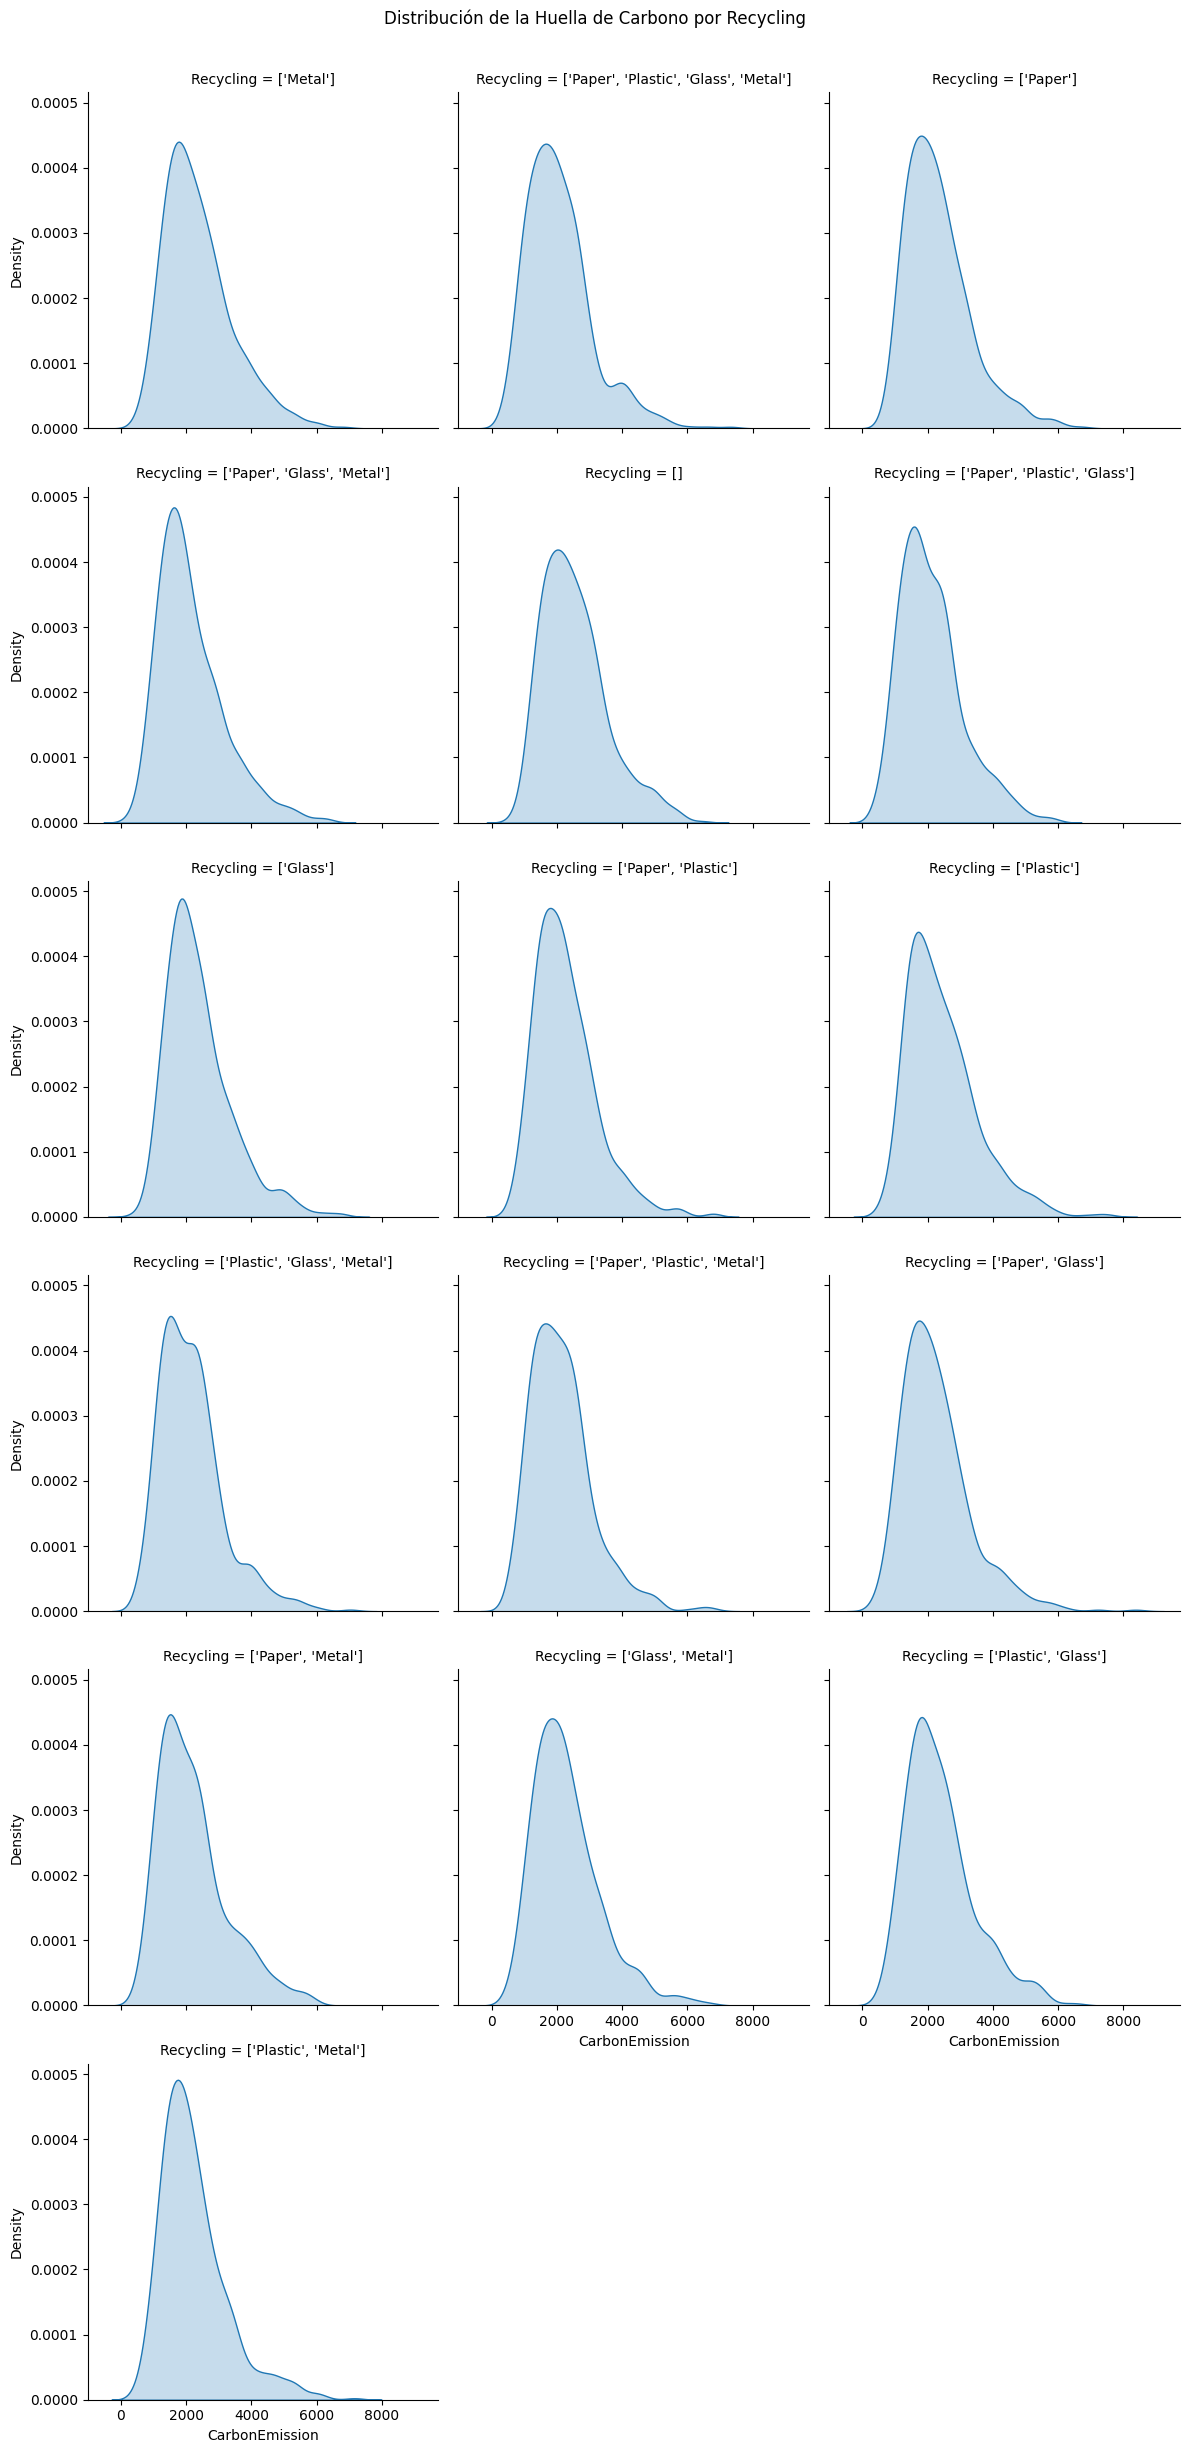

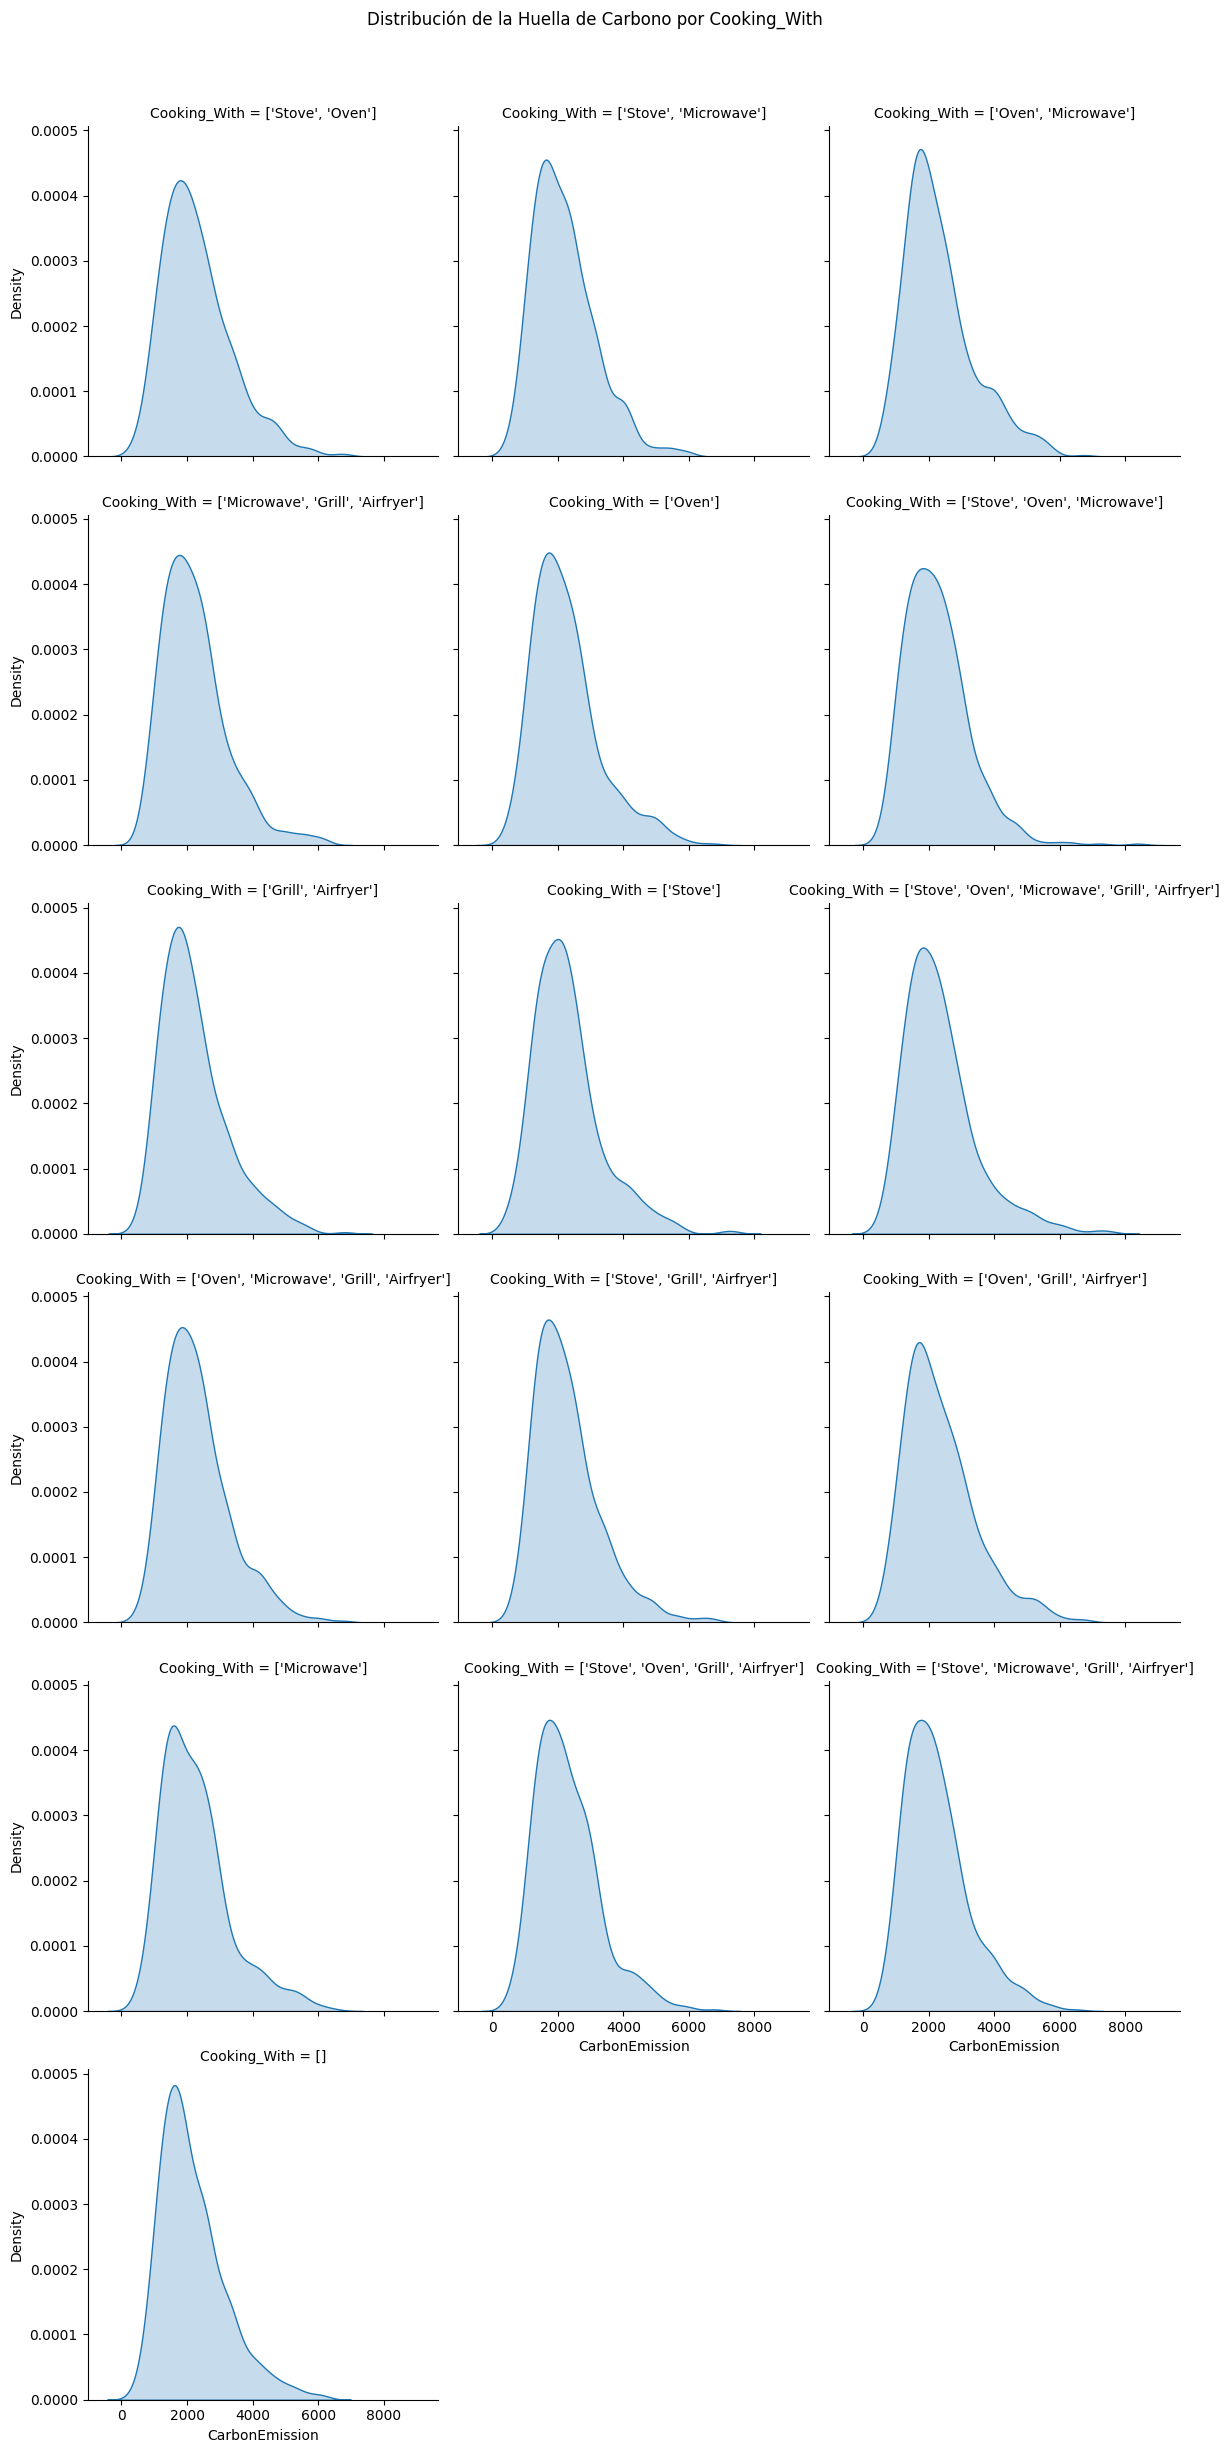

In [12]:
# Por último investigamos las distribuciones de cada categoría por separado para poder observar los comportamientos individuales mejor

# Iteramos sobre cada variable categórica para analizar la distribución de la huella de carbono por categorías
for column in categorical_columns:
    # Creamos un FacetGrid para visualizar la distribución de la huella de carbono para cada categoría de la variable    
    g = sns.FacetGrid(datos, col=column, col_wrap=3, height=4, palette="Set3")

    # Configuramos el gráfico
    g.map(sns.kdeplot, "CarbonEmission", fill=True)
    g.fig.suptitle(f"Distribución de la Huella de Carbono por {column}", y=1.02)

plt.tight_layout()
plt.show()

Se investigan más detalladamente algunas de las variables

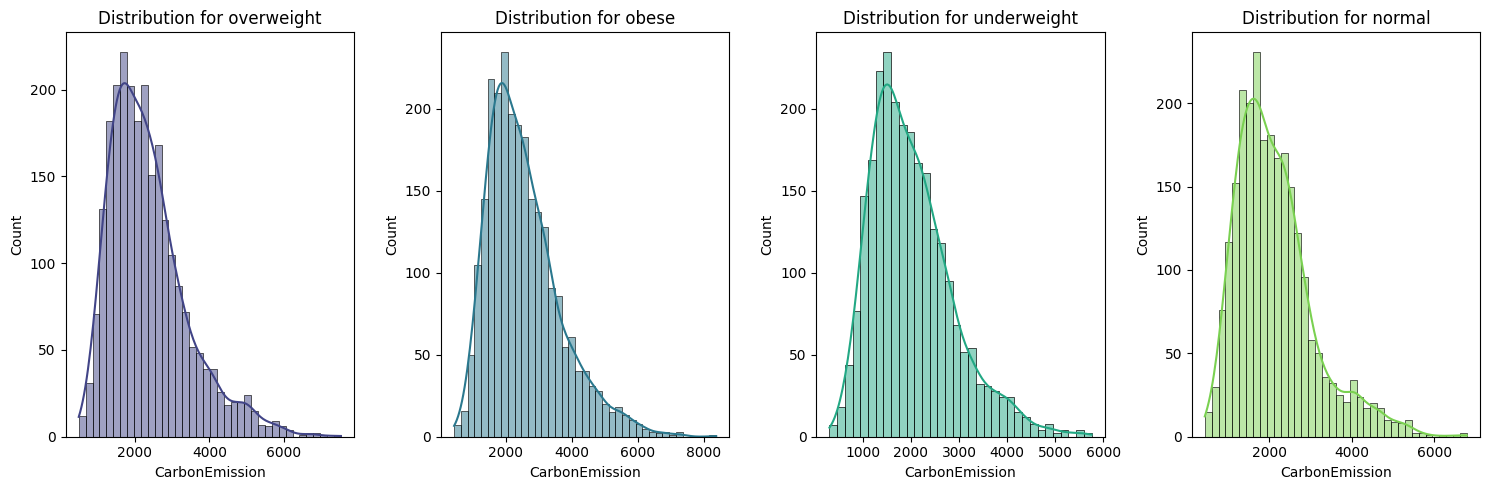

In [13]:
unique_Social_Activity = datos['BodyType'].unique()

# Configuramos la figura y los subplots para visualizar la distribución de huella de carbono
palette = sns.color_palette("viridis", len(unique_Social_Activity))
fig, axes = plt.subplots(1, 4, figsize=(15, 5)) 

for i, activity in enumerate(unique_Social_Activity):
    ax = axes[i]
    activity_df = datos[datos['BodyType'] == activity]
    sns.histplot(data=activity_df, x="CarbonEmission", color=palette[i], ax=ax, kde=True)
    ax.set_title(f"Distribution for {activity}")

plt.tight_layout()
plt.show()

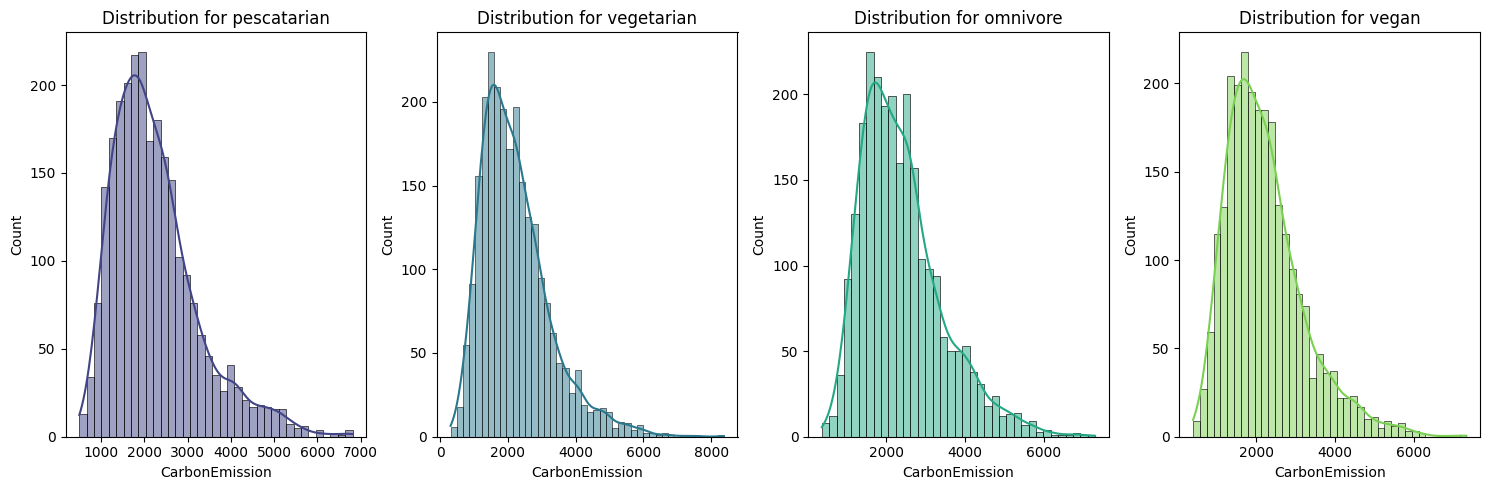

In [14]:
unique_Social_Activity = datos['Diet'].unique()

# Configuramos la figura y los subplots para visualizar la distribución de huella de carbono
palette = sns.color_palette("viridis", len(unique_Social_Activity))
fig, axes = plt.subplots(1, 4, figsize=(15, 5)) 

for i, activity in enumerate(unique_Social_Activity):
    ax = axes[i]
    activity_df = datos[datos['Diet'] == activity]
    sns.histplot(data=activity_df, x="CarbonEmission", color=palette[i], ax=ax, kde=True)
    ax.set_title(f"Distribution for {activity}")

plt.tight_layout()
plt.show()

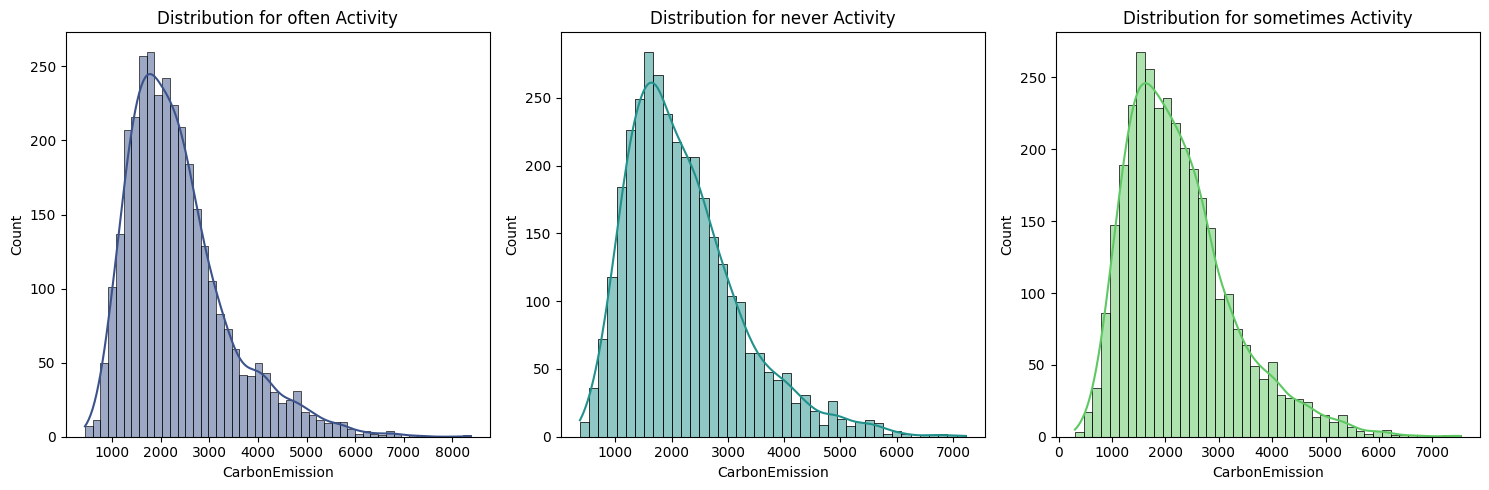

In [15]:
unique_Social_Activity = datos['SocialActivity'].unique()

# Configuramos la figura y los subplots para visualizar la distribución de huella de carbono
palette = sns.color_palette("viridis", len(unique_Social_Activity))
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

for i, activity in enumerate(unique_Social_Activity):
    ax = axes[i]
    activity_df = datos[datos['SocialActivity'] == activity]
    sns.histplot(data=activity_df, x="CarbonEmission", color=palette[i], ax=ax, kde=True)
    ax.set_title(f"Distribution for {activity} Activity")

plt.tight_layout()
plt.show()

Investigación de las variables categóricas Transport y VehicleType

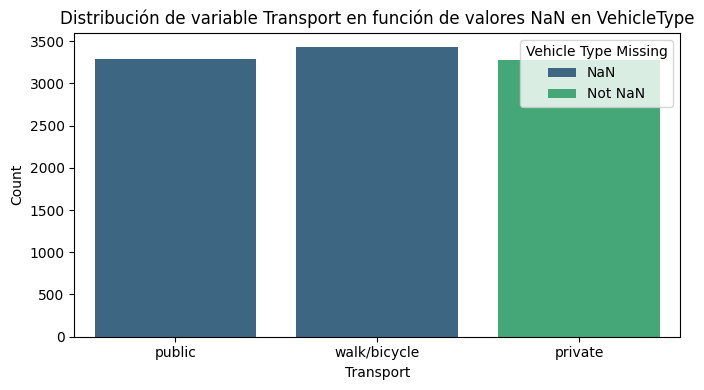

In [16]:
# Creamos una nueva columna 'Vehicle Type Missing' para indicar si el valor en 'VehicleType' es 'NaN' o no
datos['Vehicle Type Missing'] = datos['VehicleType'].apply(lambda x: 'NaN' if x == 'NaN' else 'Not NaN')

# Creamos un gráfico de conteo para visualizar la distribución de la variable 'Transport'
plt.figure(figsize=(7, 4))
sns.countplot(data=datos, x='Transport', hue='Vehicle Type Missing', palette='viridis')

# Configuramos el gráfico
plt.title('Distribución de variable Transport en función de valores NaN en VehicleType')
plt.xlabel('Transport')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
# Agrupamos los datos por 'Transport' y 'Vehicle Type Missing' para obtener los conteos
transport_vehicle_counts = datos.groupby(['Transport', 'Vehicle Type Missing']).size().reset_index(name='Count')

# Pivotamos la tabla para visualizar mejor los conteos de 'NaN' y 'Not NaN' para cada tipo de transporte
pivot_table = transport_vehicle_counts.pivot(index='Transport', columns='Vehicle Type Missing', values='Count').fillna(0)
print(pivot_table)

Vehicle Type Missing     NaN  Not NaN
Transport                            
private                  0.0   3279.0
public                3294.0      0.0
walk/bicycle          3427.0      0.0


In [18]:
datos = datos.drop(columns=['Vehicle Type Missing'])

<a id="23"></a> 
## 2.3 Visualización de las variables explicativas numéricas

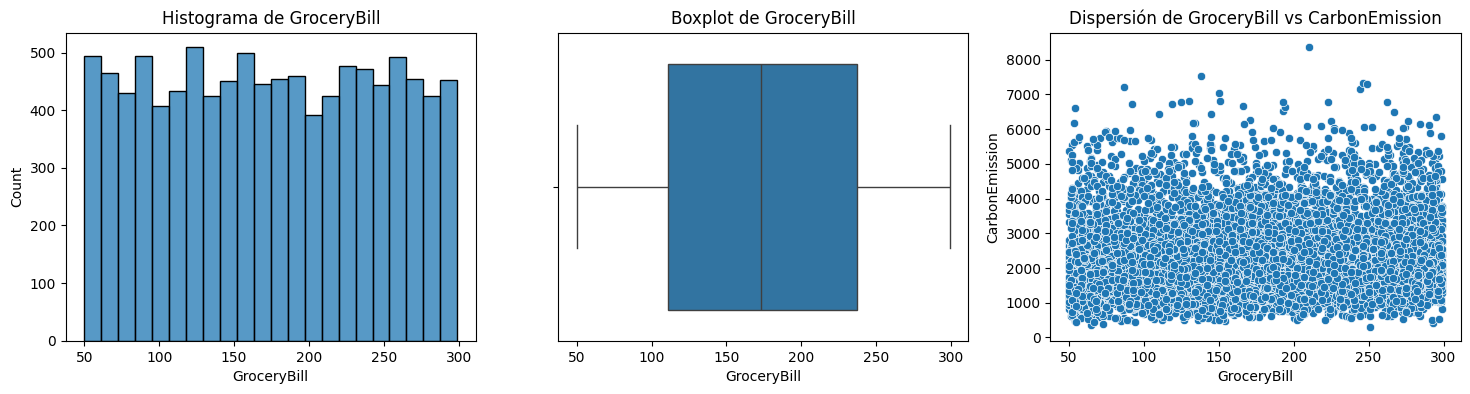

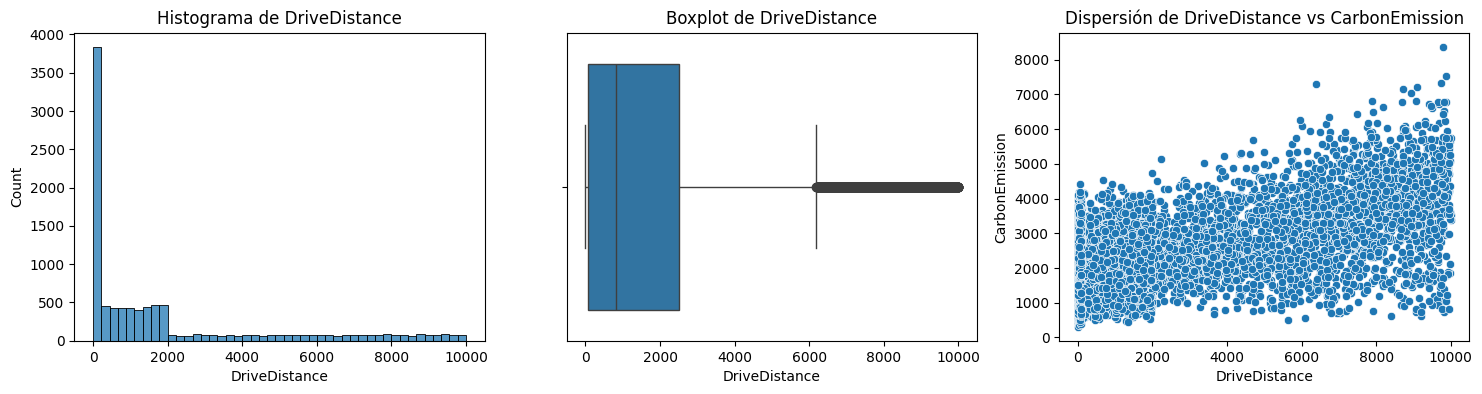

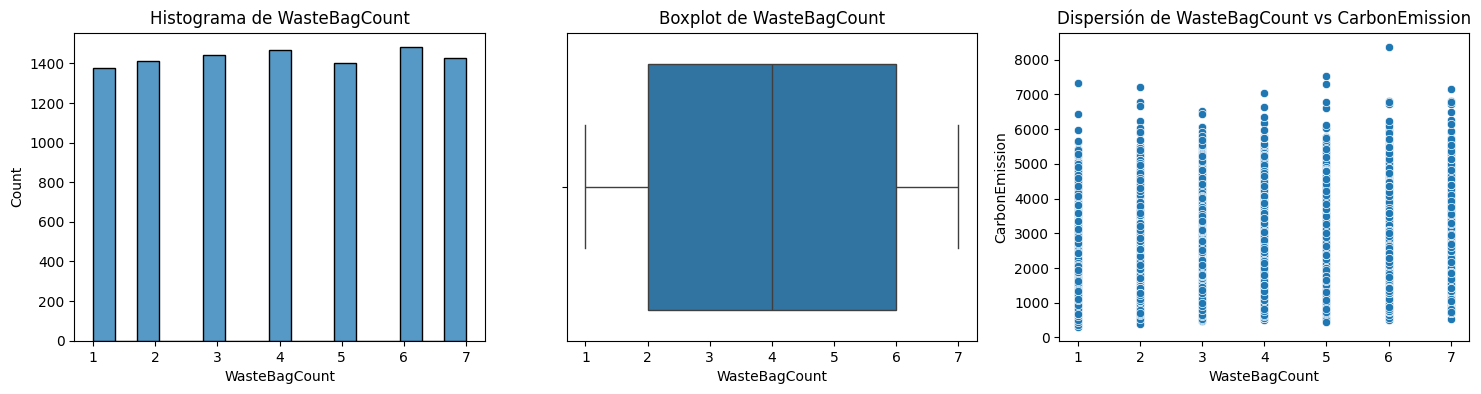

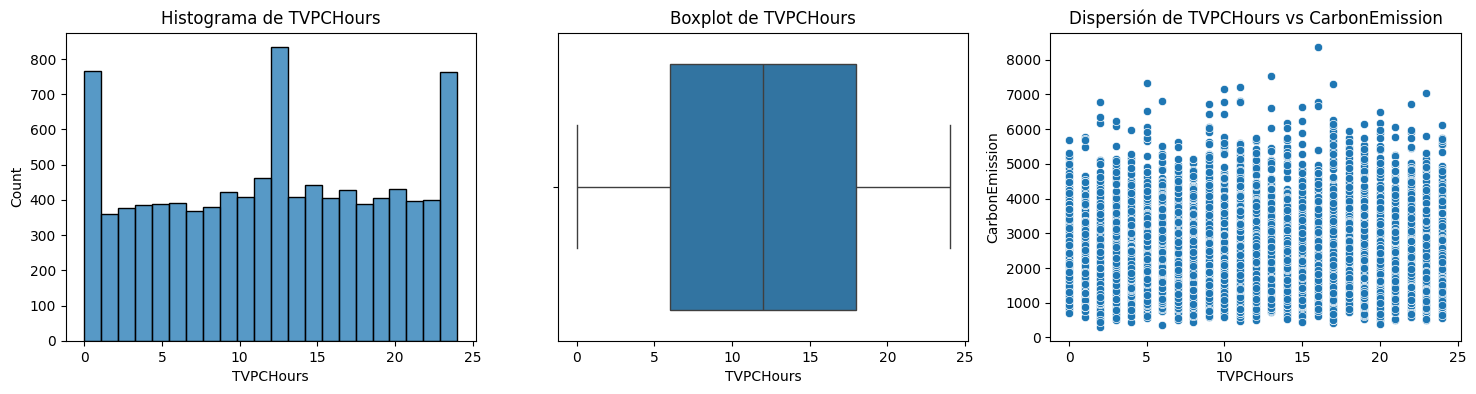

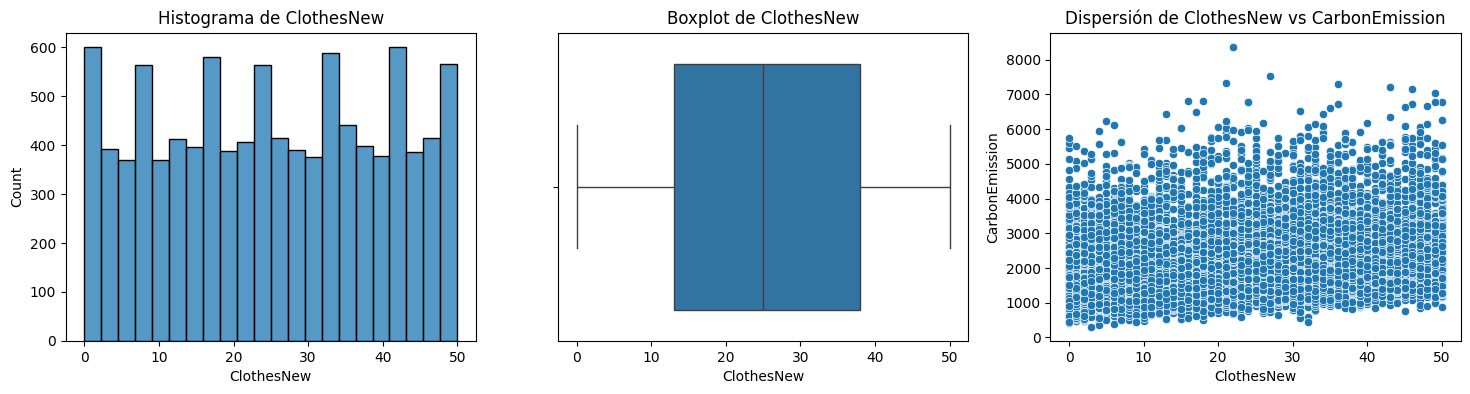

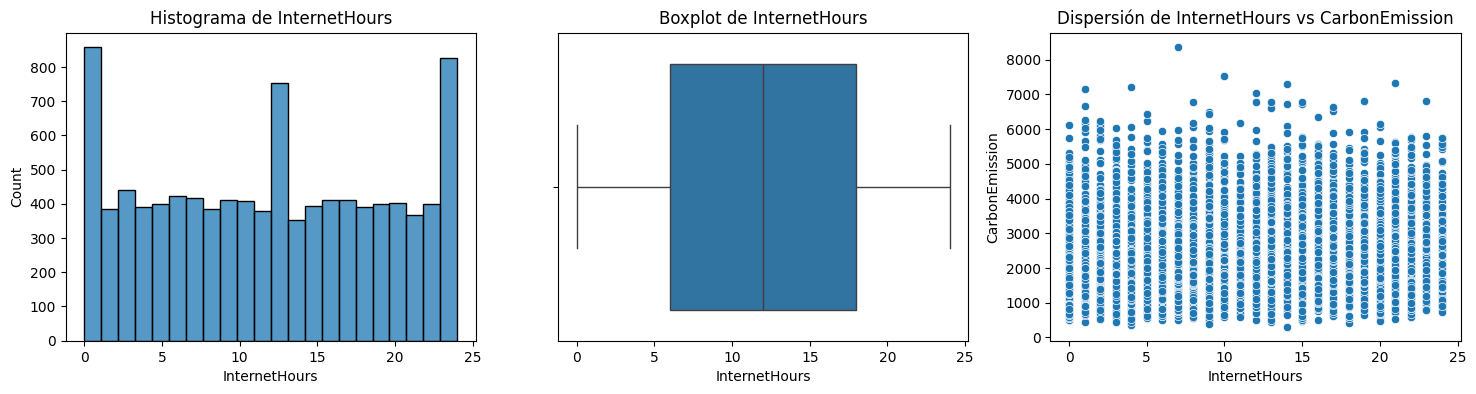

In [19]:
# Iteramos sobre cada variable numérica en el DataFrame para crear gráficos individuales de las distribuciones de las variables explicativas numéricas
for numerica in numericas:
    # Creamos una figura con tres subplots dispuestos en una fila
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Histograma: muestra la distribución de la variable numérica.
    sns.histplot(data=datos, x=datos[numerica], ax=ax1)
    ax1.set_title(f"Histograma de {numerica}")

    # Boxplot: muestra la distribución y los valores atípicos de la variable numérica.
    sns.boxplot(data=datos, x=datos[numerica], ax=ax2)
    ax2.set_title(f"Boxplot de {numerica}")

    # Diagrama de dispersión: muestra la relación entre la variable numérica y 'CarbonEmission'.
    sns.scatterplot(data=datos, x=datos[numerica], y='CarbonEmission', ax=ax3)
    ax3.set_title(f"Dispersión de {numerica} vs CarbonEmission")

    plt.show()

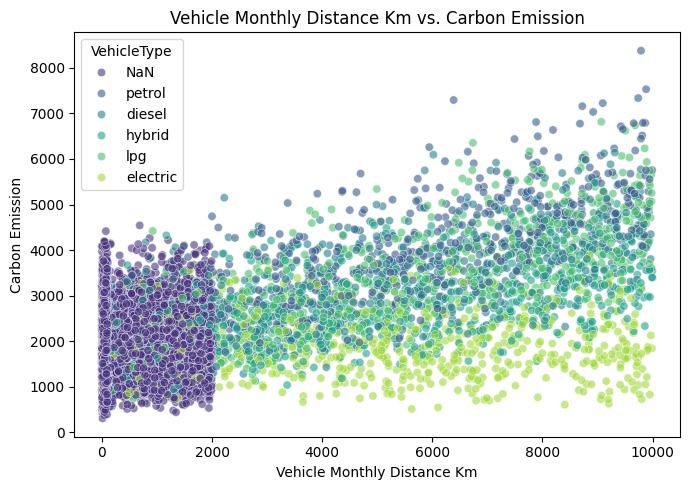

In [20]:
# Configuramos el tamaño de la figura para el gráfico
plt.figure(figsize=(7, 5))

# Creamos un gráfico de dispersión (scatter plot) para visualizar la relación entre 'DriveDistance' y 'CarbonEmission'.
# 'hue' se usa para distinguir entre diferentes tipos de vehículos ('VehicleType') con diferentes colores.
sns.scatterplot(data=datos, x="DriveDistance", y="CarbonEmission", hue="VehicleType", palette="viridis", alpha=0.6)

# Configuramos el gráfico
plt.title("Vehicle Monthly Distance Km vs. Carbon Emission")
plt.xlabel("Vehicle Monthly Distance Km")
plt.ylabel("Carbon Emission")
plt.tight_layout()
plt.show()

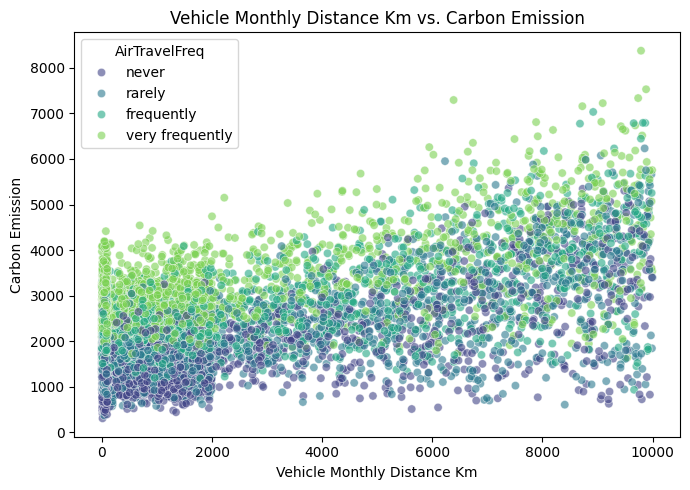

In [21]:
# Configuramos el tamaño de la figura para el gráfico
plt.figure(figsize=(7, 5))

# Creamos un gráfico de dispersión (scatter plot) para visualizar la relación entre 'DriveDistance' y 'CarbonEmission'.
# 'hue' se usa para distinguir entre diferentes tipos de vehículos ('AirTravelFreq') con diferentes colores.
hue_order = ["never", "rarely", "frequently", "very frequently"] 
sns.scatterplot(data=datos, x="DriveDistance", y="CarbonEmission", hue="AirTravelFreq", hue_order=hue_order, palette="viridis", alpha=0.6)

# Configuramos el gráfico
plt.title("Vehicle Monthly Distance Km vs. Carbon Emission")
plt.xlabel("Vehicle Monthly Distance Km")
plt.ylabel("Carbon Emission")
plt.tight_layout()
plt.show()

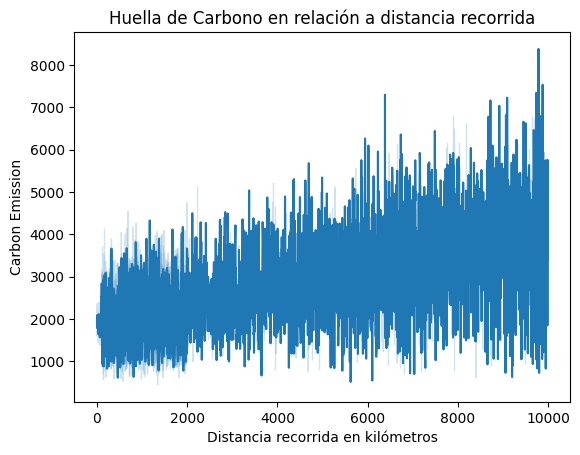

In [22]:
# Creamos un gráfico de líneas para visualizar la relación entre 'DriveDistance' y 'CarbonEmission'
# Usamos `sns.lineplot` para trazar una línea que representa cómo cambia la huella de carbono en función de la distancia recorrida
sns.lineplot(data=datos, x = "DriveDistance", y="CarbonEmission")

# Configuramos el gráfico
plt.ylabel("Carbon Emission")
plt.xlabel("Distancia recorrida en kilómetros")
plt.title("Huella de Carbono en relación a distancia recorrida")
plt.show()

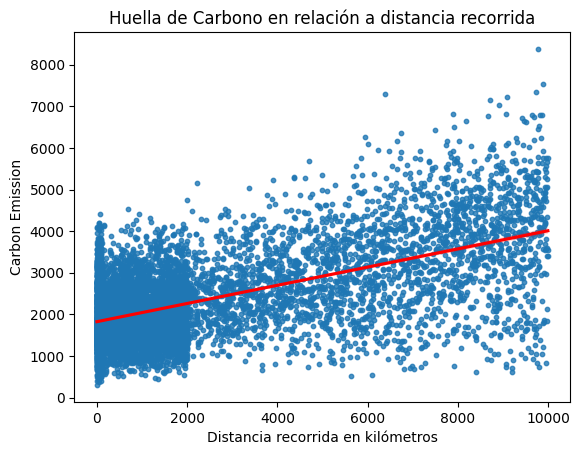

In [23]:
# Creamos un gráfico de regresión para visualizar la relación entre 'DriveDistance' y 'CarbonEmission'.
# Utilizamos `sns.regplot` para trazar tanto los puntos de datos como una línea de ajuste (regresión).
sns.regplot(data=datos, x="DriveDistance", y="CarbonEmission", scatter_kws={'s':10}, line_kws={'color':'red'})

# Configuramos el gráfico
plt.ylabel("Carbon Emission")
plt.xlabel("Distancia recorrida en kilómetros")
plt.title("Huella de Carbono en relación a distancia recorrida")
plt.show()


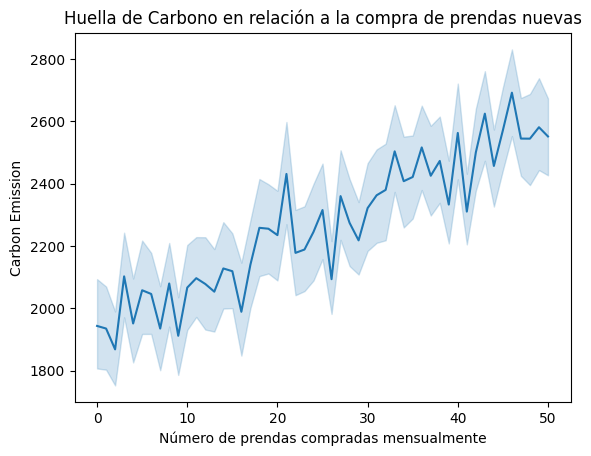

In [24]:
# Creamos un gráfico de líneas para visualizar la relación entre 'ClothesNew' y 'CarbonEmission'
# Usamos `sns.lineplot` para trazar una línea que representa cómo cambia la huella de carbono en función de la distancia recorrida
sns.lineplot(data=datos, x = "ClothesNew", y="CarbonEmission")

# Configuramos el gráfico
plt.ylabel("Carbon Emission")
plt.xlabel("Número de prendas compradas mensualmente")
plt.title("Huella de Carbono en relación a la compra de prendas nuevas")
plt.show()

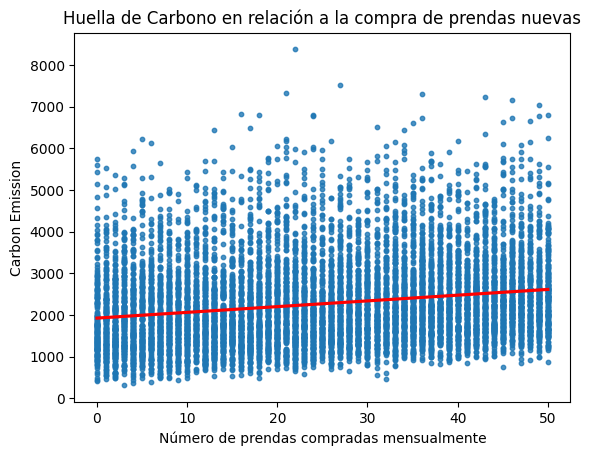

In [25]:
# Creamos un gráfico de regresión para visualizar la relación entre 'DriveDistance' y 'CarbonEmission'.
# Utilizamos `sns.regplot` para trazar tanto los puntos de datos como una línea de ajuste (regresión).
sns.regplot(data=datos, x="ClothesNew", y="CarbonEmission", scatter_kws={'s':10}, line_kws={'color':'red'})

# Configuramos el gráfico
plt.ylabel("Carbon Emission")
plt.xlabel("Número de prendas compradas mensualmente")
plt.title("Huella de Carbono en relación a la compra de prendas nuevas")
plt.show()

<a id="3"></a> 
# 3. Preparación de las variables

<a id="31"></a> 
## 3.1 Variables independientes a combinar

In [26]:
# Definimos una nueva columna 'TransportVehicleType' que inicialmente toma los valores de la columna 'VehicleType'
datos["TransportVehicleType"]=datos["VehicleType"]

# Reemplazamos los valores 'NaN' en 'TransportVehicleType' con los valores correspondientes de la columna 'Transport' y eliminamos las columnas originales
datos.loc[datos["TransportVehicleType"] == 'NaN', "TransportVehicleType"] = datos["Transport"]
datos = datos.drop(columns=['VehicleType', 'Transport'])


<a id="32"></a> 
## 3.2 Estandarización de variables numéricas

In [27]:
# Estandarizar las columnas numéricas utilizando StandardScaler.
datos_stn = pd.DataFrame(
    StandardScaler().fit_transform(datos[numericas]),  # Datos estandarizados
                                   columns=['{}_z'.format(variable) for variable in numericas],  # Nombres de columnas estandarizadas
                                   index=datos[numericas].index  # Índices (etiquetas de filas) del DataFrame
)

# Eliminar las columnas originales del DataFrame 'datos' que han sido estandarizadas e incluir las nuevas
datos_sin_numericas = datos.drop(columns=numericas)
datos = pd.concat([datos_sin_numericas, datos_stn], axis=1)

# Mostrar las primeras filas del DataFrame final para verificar
datos.head()

BodyType     Sex         Diet       ShowerFreq   EnergyHeat  \
0  overweight  female  pescatarian            daily         coal   
1       obese  female   vegetarian  less frequently  natural gas   
2  overweight    male     omnivore  more frequently         wood   
3  overweight    male     omnivore      twice a day         wood   
4       obese  female   vegetarian            daily         coal   

  SocialActivity    AirTravelFreq WasteBagSize EnergyEfficiency  \
0          often       frequently        large               No   
1          often           rarely  extra large               No   
2          never            never        small        Sometimes   
3      sometimes           rarely       medium        Sometimes   
4          often  very frequently        large              Yes   

                                Recycling                        Cooking_With  \
0                               ['Metal']                   ['Stove', 'Oven']   
1                               ['Metal']              ['Stove', 'Microwave']   
2                               ['Metal']               ['Oven', 'Microwave']   
3  ['Paper', 'Plastic', 'Glass', 'Metal']  ['Microwave', 'Grill', 'Airfryer']   
4                               ['Paper']                            ['Oven']   

   CarbonEmission TransportVehicleType  GroceryBill_z  DriveDistance_z  \
0            2238               public       0.777025        -0.657677   
1            1892         walk/bicycle      -0.828947        -0.730251   
2            2595               petrol      -0.496677         0.159055   
3            1074         walk/bicycle      -0.233630        -0.706782   
4            4743               diesel       1.275430         2.320034   

   WasteBagCount_z  TVPCHours_z  ClothesNew_z  InternetHours_z  
0        -0.012360    -0.723218      0.060621        -1.496402  
1        -0.514803    -0.441767      0.877059        -0.946714  
2        -1.519689     0.261863      1.489387        -0.809292  
3        -0.514803     1.106218     -1.368146        -0.671870  
4        -1.519689    -1.286122     -1.368146        -0.809292

<a id="33"></a> 
## 3.3 Variables independientes con posibles combinaciones de respuestas

In [28]:
# Manejo de la columna 'Recycling'

# Creamos un conjunto con los valores únicos posibles en la columna 'Recycling'
# Asignamos 1 si el valor está presente en la columna original, de lo contrario, asignamos 0
unique_values_Recycling= set([item for sublist in datos['Recycling'].unique() for item in eval(sublist)])
for item in unique_values_Recycling:
    datos['Recycling'+str(item)] = datos['Recycling'].apply(lambda x: 1 if item in x else 0)

# Manejo de la columna 'Cooking_with'
# Creamos un conjunto con los valores únicos posibles en la columna 'Recycling'
# Asignamos 1 si el valor está presente en la columna original, de lo contrario, asignamos 0
unique_values_cooking_With= set([item for sublist in datos['Cooking_With'].unique() for item in eval(sublist)]) 
for item in unique_values_cooking_With:
    datos['CookingWith'+str(item)] = datos['Cooking_With'].apply(lambda x: 1 if item in x else 0)

# Eliminamos las columnas originales 'Recycling' y 'Cooking_With' ya que hemos creado nuevas columnas binarias
datos = datos.drop(columns=['Recycling', 'Cooking_With'])

<a id="34"></a> 
## 3.4 Codificación de variables independientes con una sola respuesta

In [29]:
# Definimos los codificadores para las columnas
encoders = {
    "BodyType": OrdinalEncoder(categories=[['underweight', 'normal', 'overweight', 'obese']]),
    "Sex": LabelBinarizer(),
    "ShowerFreq": OrdinalEncoder(categories=[['less frequently', 'more frequently', 'daily', 'twice a day']]),
    "EnergyHeat": OneHotEncoder(categories=[['electricity', 'natural gas', 'coal', 'wood']], sparse_output=False),
    "TransportVehicleType": OneHotEncoder(categories=[['walk/bicycle', 'public','electric', 'hybrid', 'lpg' ,'petrol','diesel']], sparse_output=False),
    "SocialActivity": OrdinalEncoder(categories=[['never', 'sometimes', 'often']]),
    "AirTravelFreq": OrdinalEncoder(categories=[['never', 'rarely', 'frequently', 'very frequently']]),
    "WasteBagSize": OrdinalEncoder(categories=[['small', 'medium', 'large', 'extra large']]),
    "EnergyEfficiency": OrdinalEncoder(categories=[['No','Sometimes','Yes']]),
    "Diet": OneHotEncoder(categories=[['pescatarian', 'vegetarian', 'omnivore', 'vegan']], sparse_output=False)
}

# Aplicamos las transformaciones en las columnas correspondientes
for column, encoder in encoders.items():
    print(column)
    print(encoder)
    print(' ')

    # Para columnas con OneHotEncoder
    if column == 'EnergyHeat' or column == 'TransportVehicleType' or column == 'Diet':
        # Aplicamos la codificación OneHotEncoder
        encoded_data = encoder.fit_transform(datos[column].array.reshape(-1, 1))
        encoded_columns = encoder.get_feature_names_out([column])
        
        # Creamos un DataFrame con las columnas codificadas y lo unimos al original
        onehot_df = pd.DataFrame(encoded_data, 
                                 index = datos.index,
                                 columns=encoded_columns)
        onehot_df = onehot_df.astype(int)
        datos = datos.join(onehot_df)
        datos = datos.drop(columns=[column])
    
    # Para columnas con OrdinalEncoder y LabelBinarizer
    else:
        datos[column] = encoder.fit_transform(datos[column].array.reshape(-1, 1))

# Verificamos las primeras filas del DataFrame transformado
datos.head(5)

BodyType
OrdinalEncoder(categories=[['underweight', 'normal', 'overweight', 'obese']])
 
Sex
LabelBinarizer()
 
ShowerFreq
OrdinalEncoder(categories=[['less frequently', 'more frequently', 'daily',
                            'twice a day']])
 
EnergyHeat
OneHotEncoder(categories=[['electricity', 'natural gas', 'coal', 'wood']],
              sparse_output=False)
 
TransportVehicleType
OneHotEncoder(categories=[['walk/bicycle', 'public', 'electric', 'hybrid',
                           'lpg', 'petrol', 'diesel']],
              sparse_output=False)
 
SocialActivity
OrdinalEncoder(categories=[['never', 'sometimes', 'often']])
 
AirTravelFreq
OrdinalEncoder(categories=[['never', 'rarely', 'frequently',
                            'very frequently']])
 
WasteBagSize
OrdinalEncoder(categories=[['small', 'medium', 'large', 'extra large']])
 
EnergyEfficiency
OrdinalEncoder(categories=[['No', 'Sometimes', 'Yes']])
 
Diet
OneHotEncoder(categories=[['pescatarian', 'vegetarian', 'omnivore', 've

BodyType  Sex  ShowerFreq  SocialActivity  AirTravelFreq  WasteBagSize  \
0       2.0    0         2.0             2.0            2.0           2.0   
1       3.0    0         0.0             2.0            1.0           3.0   
2       2.0    1         1.0             0.0            0.0           0.0   
3       2.0    1         3.0             1.0            1.0           1.0   
4       3.0    0         2.0             2.0            3.0           2.0   

   EnergyEfficiency  CarbonEmission  GroceryBill_z  DriveDistance_z  \
0               0.0            2238       0.777025        -0.657677   
1               0.0            1892      -0.828947        -0.730251   
2               1.0            2595      -0.496677         0.159055   
3               1.0            1074      -0.233630        -0.706782   
4               2.0            4743       1.275430         2.320034   

   WasteBagCount_z  TVPCHours_z  ClothesNew_z  InternetHours_z  \
0        -0.012360    -0.723218      0.060621        -1.496402   
1        -0.514803    -0.441767      0.877059        -0.946714   
2        -1.519689     0.261863      1.489387        -0.809292   
3        -0.514803     1.106218     -1.368146        -0.671870   
4        -1.519689    -1.286122     -1.368146        -0.809292   

   RecyclingMetal  RecyclingPlastic  RecyclingPaper  RecyclingGlass  \
0               1                 0               0               0   
1               1                 0               0               0   
2               1                 0               0               0   
3               1                 1               1               1   
4               0                 0               1               0   

   CookingWithGrill  CookingWithOven  CookingWithMicrowave  \
0                 0                1                     0   
1                 0                0                     1   
2                 0                1                     1   
3                 1                0                     1   
4                 0                1                     0   

   CookingWithAirfryer  CookingWithStove  EnergyHeat_electricity  \
0                    0                 1                       0   
1                    0                 1                       0   
2                    0                 0                       0   
3                    1                 0                       0   
4                    0                 0                       0   

   EnergyHeat_natural gas  EnergyHeat_coal  EnergyHeat_wood  \
0                       0                1                0   
1                       1                0                0   
2                       0                0                1   
3                       0                0                1   
4                       0                1                0   

   TransportVehicleType_walk/bicycle  TransportVehicleType_public  \
0                                  0                            1   
1                                  1                            0   
2                                  0                            0   
3                                  1                            0   
4                                  0                            0   

   TransportVehicleType_electric  TransportVehicleType_hybrid  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   TransportVehicleType_lpg  TransportVehicleType_petrol  \
0                         0                            0   
1                         0                            0   
2                         0                            1   
3                         0                            0   
4                     

<a id="35"></a> 
## 3.5 Comprobación de los datos

In [30]:
# Generamos una lista con los nombres de todas las variables del DataFrame, y se distingue la variable objetivo de las explicativas
variables = list(datos.columns)

VarObj = ['CarbonEmission']
VarExp = [var for var in variables if var != 'CarbonEmission']

Número de filas duplicadas: 0
BodyType                             0
Sex                                  0
ShowerFreq                           0
SocialActivity                       0
AirTravelFreq                        0
WasteBagSize                         0
EnergyEfficiency                     0
CarbonEmission                       0
GroceryBill_z                        0
DriveDistance_z                      0
WasteBagCount_z                      0
TVPCHours_z                          0
ClothesNew_z                         0
InternetHours_z                      0
RecyclingMetal                       0
RecyclingPlastic                     0
RecyclingPaper                       0
RecyclingGlass                       0
CookingWithGrill                     0
CookingWithOven                      0
CookingWithMicrowave                 0
CookingWithAirfryer                  0
CookingWithStove                     0
EnergyHeat_electricity               0
EnergyHeat_natural gas            

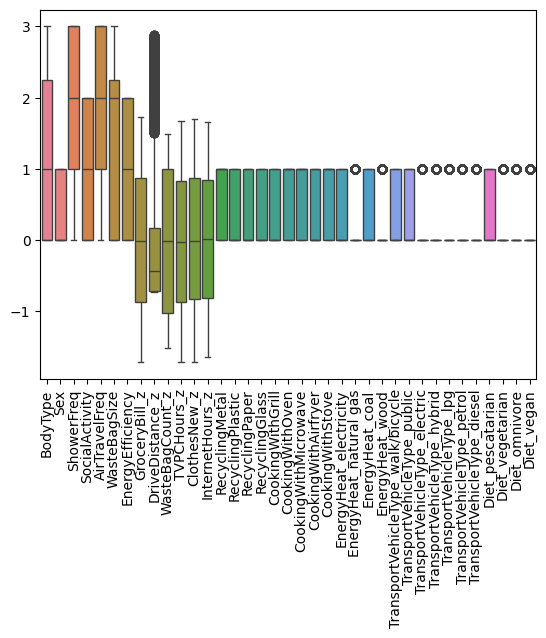

In [31]:
# Valores duplicados
duplicados = datos.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")

# Valores faltantes
print(datos.isnull().sum())

# Verificación tipos de datos
print(datos.dtypes)

# Valores atípicos
sns.boxplot(data=datos[VarExp])
plt.xticks(rotation=90)
plt.show()

In [32]:
# Calcular el número de valores únicos por columna
distinct_values = datos.nunique()
print(distinct_values)
print(datos.dtypes)

BodyType                                4
Sex                                     2
ShowerFreq                              4
SocialActivity                          3
AirTravelFreq                           4
WasteBagSize                            4
EnergyEfficiency                        3
CarbonEmission                       3509
GroceryBill_z                         250
DriveDistance_z                      4003
WasteBagCount_z                         7
TVPCHours_z                            25
ClothesNew_z                           51
InternetHours_z                        25
RecyclingMetal                          2
RecyclingPlastic                        2
RecyclingPaper                          2
RecyclingGlass                          2
CookingWithGrill                        2
CookingWithOven                         2
CookingWithMicrowave                    2
CookingWithAirfryer                     2
CookingWithStove                        2
EnergyHeat_electricity            

<a id="4"></a> 
# 4. Relaciones entre variables

<a id="41"></a> 
## 4.1 Correlaciones entre variables

In [33]:
# Obtener la lista de columnas
columns = datos.columns.tolist()

# Mover 'CarbonEmission' al final de la lista
columns.append(columns.pop(columns.index('CarbonEmission')))

# Reordenar el DataFrame con la columna 'CarbonEmission' al final
datos = datos[columns]

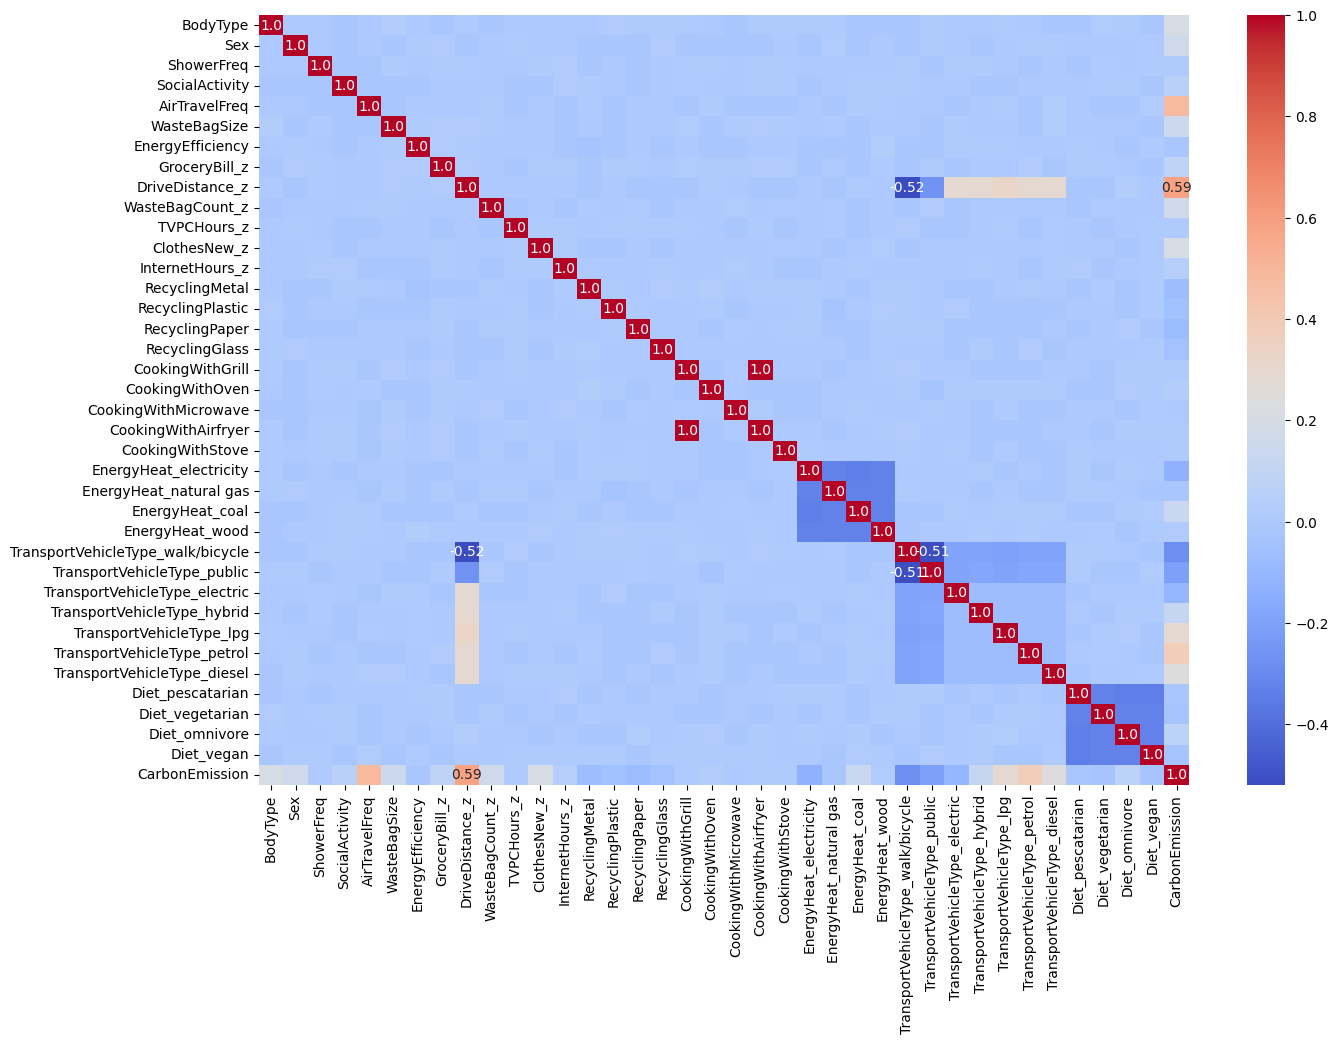

In [34]:
# Calcular la matriz de correlación entre todas las variables
corr_matrix = datos.corr()

# Configurar el gráfico para que solo se muestren anotaciones en los valores de correlación > 0.5
# Esto resalta únicamente las correlaciones fuertes y deja las débiles sin anotaciones
rounded_corr_matrix = corr_matrix.round(2)
annot_matrix = rounded_corr_matrix.copy()
annot_matrix = annot_matrix.where(corr_matrix.abs() > 0.5)

# Reemplazar los NaN por una cadena vacía para evitar que se muestren en el heatmap
annot_matrix = annot_matrix.fillna('')

# Congfigurar el gráfico
plt.figure(figsize=(15, 10))
sns.heatmap(rounded_corr_matrix, cmap='coolwarm', annot=annot_matrix, fmt="")
plt.show()

<a id="42"></a> 
## 4.2 Relaciones entre variables con V de Cramer y Chi Cuadrado

Para cuantificar las relaciones entre las variables del conjunto de datos, se utilizará el test de Chicuadrado
(χ²). Este test permite evaluar la existencia de una asociación estadísticamente significativa
entre dos variables. Adicionalmente, se calculará el coeficiente V de Cramer para cada variable original
con la variable objetivo correspondiente

In [35]:
def Vcramer(v, target):
    """
    Calcula el coeficiente V de Cramer entre dos variables. Si alguna de ellas es continua, la discretiza.

    Datos de entrada:
    - v: Serie de datos categÃ³ricos o cuantitativos.
    - target: Serie de datos categÃ³ricos o cuantitativos.

    Datos de salida:
    - Coeficiente V de Cramer que mide la asociaciÃ³n entre las dos variables.
    """

    if v.dtype == 'float64' or v.dtype == 'int64' and v.nunique() > 2:
        # Si v es numérica, la discretiza en intervalos y rellena los valores faltantes
        p = sorted(list(set(v.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))))
        v = pd.cut(v, bins=p)
        v = v.fillna(v.min())

    if target.dtype == 'float64' or target.dtype == 'int64' and v.nunique() > 2:
        # Si target es numérica, la discretiza en intervalos y rellena los valores faltantes
        p = sorted(list(set(target.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))))
        target = pd.cut(target, bins=p)
        target = target.fillna(target.min())

    # Calcula una tabla de contingencia entre v y target
    tabla_cruzada = pd.crosstab(v, target)
    
    # Calcula el chi-cuadrado y el coeficiente V de Cramer
    chi2 = chi2_contingency(tabla_cruzada)[0]
    n = tabla_cruzada.sum().sum()
    v_cramer = np.sqrt(chi2 / (n * (min(tabla_cruzada.shape) - 1)))

    return v_cramer

In [36]:
def graficoVcramer(matriz, target):
    """
    Genera un grÃ¡fico de barras horizontales que muestra el coeficiente V de Cramer entre cada columna de matriz y la variable target.

    Datos de entrada:
    - matriz: DataFrame con las variables a comparar.
    - target: Serie de la variable objetivo (categÃ³rica).

    Datos de salida:
    """

    # Calcula el coeficiente V de Cramer para cada columna de matriz y target
    salidaVcramer = {x: Vcramer(matriz[x].squeeze(), target.squeeze()) for x in matriz.columns}
    print(salidaVcramer)
    
    # Ordena los resultados en orden descendente por el coeficiente V de Cramer
    sorted_data = dict(sorted(salidaVcramer.items(), key=lambda item: item[1], reverse=True))

    # Crea el grÃ¡fico de barras horizontales
    plt.figure(figsize=(20, 12))
    plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color='skyblue')
    plt.xlabel('V de Cramer')
    plt.show()

{'BodyType': 0.14235250519587506, 'Sex': 0.5952491369191636, 'ShowerFreq': 0.025460320770804543, 'SocialActivity': 0.5941663976549145, 'AirTravelFreq': 0.43123541993360337, 'WasteBagSize': 0.11061767497617049, 'EnergyEfficiency': 0.5849467675545326, 'GroceryBill_z': 0.047985542202580105, 'DriveDistance_z': 0.27408468227932015, 'WasteBagCount_z': 0.095934491216027, 'TVPCHours_z': 0.017513963579432454, 'ClothesNew_z': 0.12164784881289023, 'InternetHours_z': 0.037022929112716076, 'RecyclingMetal': 0.5918629619372979, 'RecyclingPlastic': 0.5931716001459423, 'RecyclingPaper': 0.5859205205701488, 'RecyclingGlass': 0.5959134007082039, 'CookingWithGrill': 0.5905539447212004, 'CookingWithOven': 0.5873484303048224, 'CookingWithMicrowave': 0.593123531760101, 'CookingWithAirfryer': 0.5905539447212004, 'CookingWithStove': 0.5975519707004231, 'EnergyHeat_electricity': 0.6079213859135615, 'EnergyHeat_natural gas': 0.581977213643523, 'EnergyHeat_coal': 0.6166242692287052, 'EnergyHeat_wood': 0.58685881

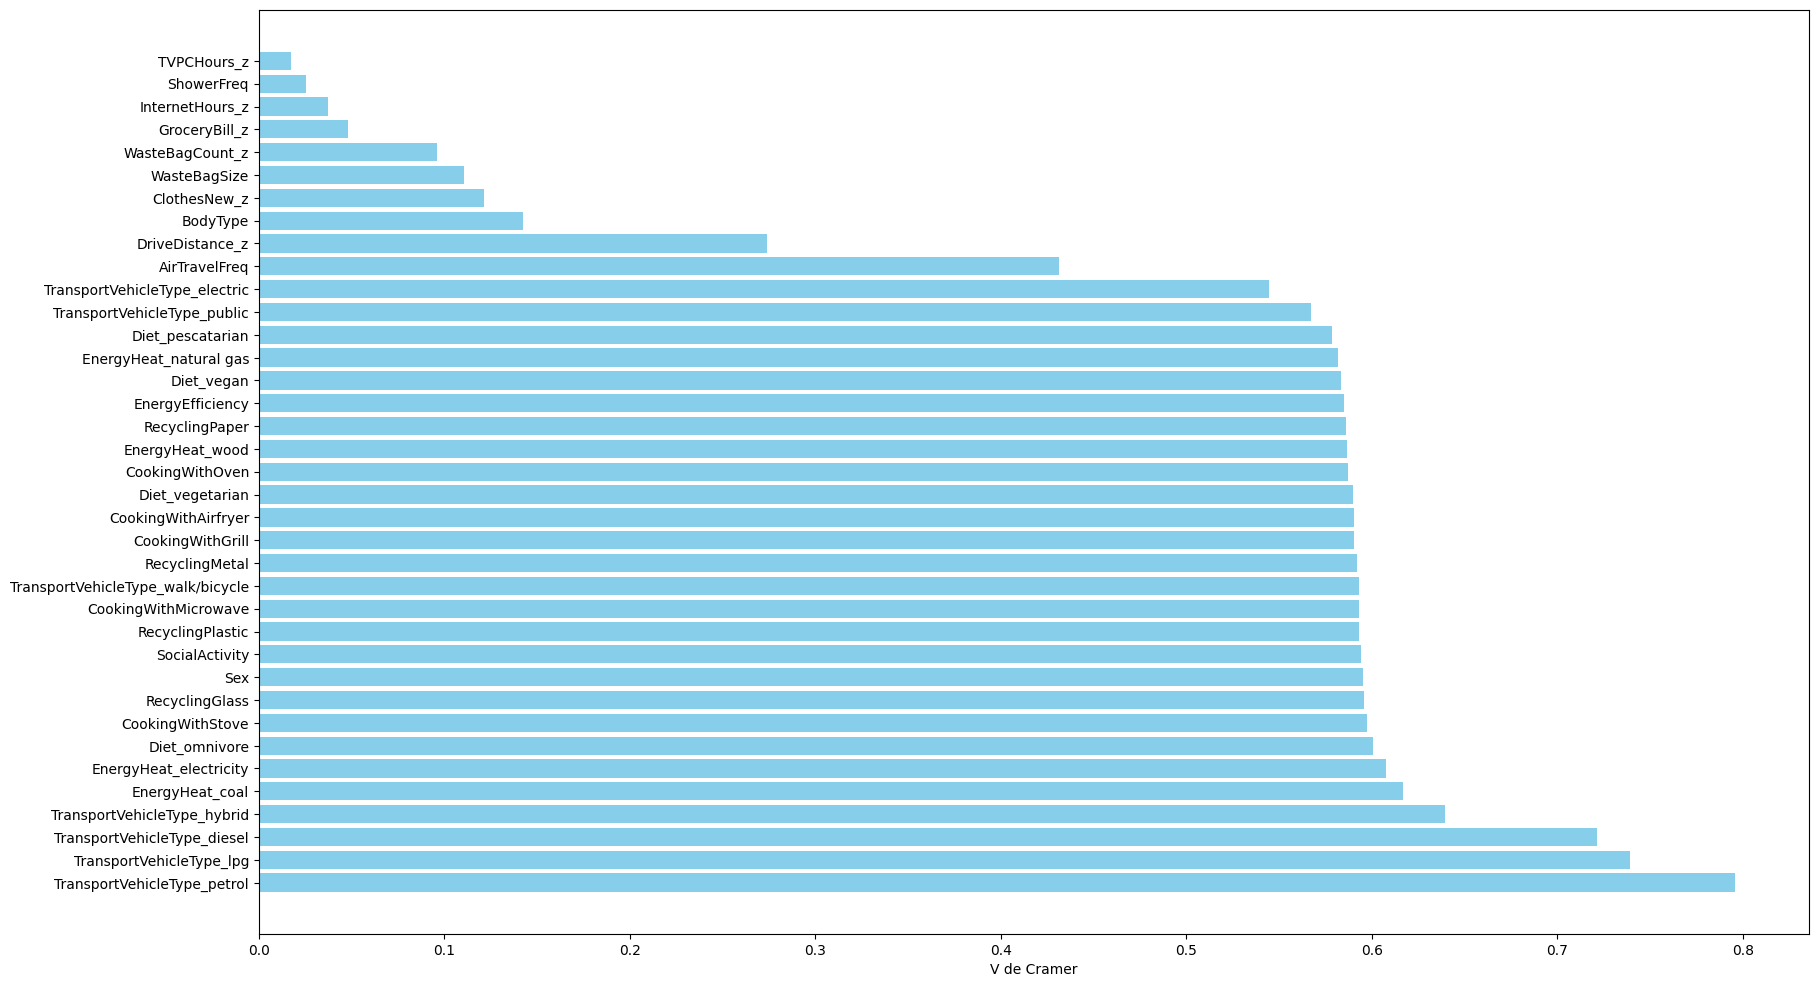

In [37]:
# Relación de cada variable de entrada con la variable objetivo, permiter observar la importancia de las variables
graficoVcramer(datos[VarExp], datos[VarObj])

In [38]:
# Crear una DataFrame para almacenar los resultados del coeficiente V de Cramer
V = [[variable, VarObj, Vcramer(datos[variable].squeeze(), datos[VarObj].squeeze())] for variable in variables]
VCramer_Dataframe = pd.DataFrame(V, columns=['Variable', 'Objetivo', 'Vcramer'])

# Relación entre las variables explicativas y la variabje objetivo
matriz_p_obj = pd.DataFrame(index=datos.columns, columns=VarObj)
matriz_p_asociacion_obj = pd.DataFrame(index=datos.columns, columns=VarObj)

# Iterar sobre todas las columnas de datos_muestra_imputados
for var1 in datos.columns:
    # Tabla cruzada entre la variable de datos_muestra_imputados y varObj
    tabla_cruzada = pd.crosstab(datos[var1], VarObj)
    # Realizar la prueba de Chi-cuadrado
    chi2val, p, dof, expected = chi2_contingency(tabla_cruzada)
    # Guardar el valor de p en la matriz
    matriz_p_obj.loc[var1, VarObj] = p
    matriz_p_asociacion_obj.loc[var1, VarObj] = 0 if p >= 0.05 else 1

In [39]:
# Relación entre las variables explicativas (dos a dos)
matriz_p = pd.DataFrame(index=datos.columns, columns=datos.columns)
matriz_p_asociacion = pd.DataFrame(index=datos.columns, columns=datos.columns)

# Iterar sobre todas las combinaciones posibles de variables
for var1 in datos.columns:
    for var2 in datos.columns:
        # Tabla cruzada entre las dos variables
        tabla_cruzada = pd.crosstab(datos[var1], datos[var2])
        # Realizar la prueba de Chi-cuadrado
        chi2val, p, dof, expected = chi2_contingency(tabla_cruzada)
        # Guardar el valor de p en la matriz
        matriz_p.loc[var1, var2] = p
        matriz_p_asociacion.loc[var1, var2] = 0 if p >= 0.05 else 1

# Correlación entre variables numéricas
corr_numericas = datos.corr()
# print(corr_numericas)

<a id="5"></a> 
# 5. Análisis de Componentes Principales

In [40]:
# Crea una instancia de Análisis de Componentes Principales (ACP):
# - Utilizamos PCA(n_components=4) para crear un objeto PCA que realizará un análisis de componentes principales.
# - Establecemos n_components en 4 para retener el maximo de las componentes principales (maximo= numero de variables).
pca_4 = PCA(n_components=4)

# Aplicar el Análisis de Componentes Principales (ACP) a los datos estandarizados:
# - Usamos pca.fit(notas_estandarizadas) para ajustar el modelo de ACP a los datos estandarizados.
datos_selected = datos[VarExp]
fit_4 = pca_4.fit(datos_selected)

# Obtener los autovalores asociados a cada componente principal.
autovalores_4 = fit_4.explained_variance_

# Obtener los autovectores asociados a cada componente principal y transponerlos.
autovectores_4 = pd.DataFrame(pca_4.components_.T,
                            columns = ['Autovector {}'.format(i) for i in range(1, fit_4.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in VarExp])

# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada_4 = fit_4.explained_variance_ratio_

# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada_4 = np.cumsum(var_explicada_4)

# Crear un DataFrame de pandas con los datos anteriores y establecer índice.
data_4 = {'Autovalores': autovalores_4, 'Variabilidad Explicada': var_explicada_4, 'Variabilidad Acumulada': var_acumulada_4}
tabla_4 = pd.DataFrame(data_4, index=['Componente {}'.format(i) for i in range(1, fit_4.n_components_+1)])

# Imprimir resultados
print(tabla_4)
print(autovectores_4)

              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     1.300857                0.076104                0.076104
Componente 2     1.266597                0.074100                0.150204
Componente 3     1.244398                0.072801                0.223005
Componente 4     1.218301                0.071274                0.294280
                                     Autovector 1  Autovector 2  Autovector 3  \
BodyType_z                               0.534740     -0.584109      0.225457   
Sex_z                                   -0.002258      0.001354      0.000418   
ShowerFreq_z                             0.253080      0.646190      0.685253   
SocialActivity_z                        -0.030611     -0.007798     -0.036117   
AirTravelFreq_z                         -0.347710     -0.474512      0.679018   
WasteBagSize_z                           0.714286     -0.034847     -0.093702   
EnergyEfficiency_z                       0.013614      0.002156

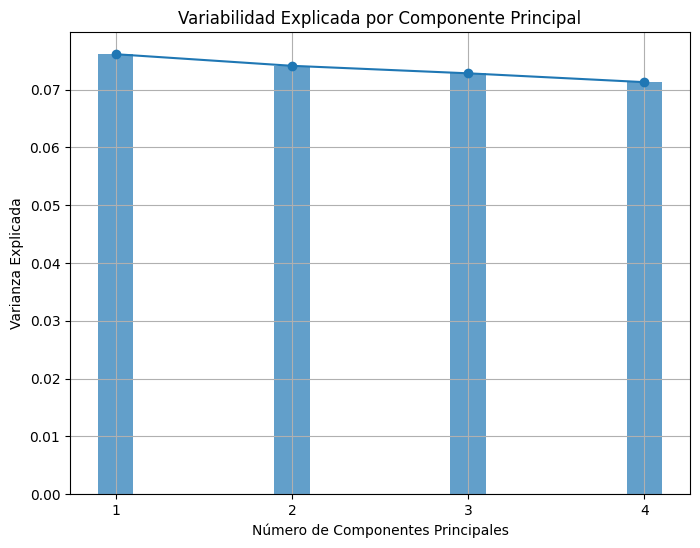

In [41]:
# Gráfico de la varianza explicada
def plot_varianza_explicada(var_explicada, n_components):
    """
    Representa la variabilidad explicada
    Args:
      var_explicada (array): Un array que contiene el porcentaje de varianza explicada
        por cada componente principal. Generalmente calculado como
        var_explicada = fit.explained_variance_ratio_ * 100.
      n_components (int): El número total de componentes principales.
        Generalmente calculado como fit.n_components.
    """
    # Crear un rango de números de componentes principales de 1 a n_components
    num_componentes_range = np.arange(1, n_components + 1)

    # Crear una figura de tamaño 8x6
    plt.figure(figsize=(8, 6))

    # Trazar la varianza explicada en función del número de componentes principales
    plt.plot(num_componentes_range, var_explicada, marker='o')

    # Etiquetas de los ejes x e y
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada')

    # Título del gráfico
    plt.title('Variabilidad Explicada por Componente Principal')

    # Establecer las marcas en el eje x para que coincidan con el número de componentes
    plt.xticks(num_componentes_range)

    # Mostrar una cuadrícula en el gráfico
    plt.grid(True)

    # Agregar barras debajo de cada punto para representar el porcentaje de variabilidad explicada
    # - 'width': Ancho de las barras de la barra. En este caso, se establece en 0.2 unidades.
    # - 'align': Alineación de las barras con respecto a los puntos en el eje x.
    #   'center' significa que las barras estarán centradas debajo de los puntos.
    # - 'alpha': Transparencia de las barras. Un valor de 0.7 significa que las barras son 70% transparentes.
    plt.bar(num_componentes_range, var_explicada, width=0.2, align='center', alpha=0.7)

    # Mostrar el gráfico
    plt.show()

plot_varianza_explicada(var_explicada_4, fit_4.n_components_)

<a id="6"></a> 
# 6. Clustering

<a id="61"></a> 
## 6.1 Selección del número óptimo de clusters

In [42]:
# Calcular las distancias euclidianas por pares
distance_std = distance.cdist(datos_selected, datos_selected,"euclidean")
print(distance_std[:5,:5].round(2))

# Crear un DataFrame a partir de la matriz de distancias
# Se convierte la matriz de distancias en un DataFrame, asignando las mismas etiquetas de fila y columna que el DataFrame original 'datos_selected'.
df_std_distance = pd.DataFrame(distance_std, index = datos_selected.index, columns = datos_selected.index)

[[0.   4.35 5.57 5.23 5.22]
 [4.35 0.   5.37 5.9  6.52]
 [5.57 5.37 0.   5.07 6.95]
 [5.23 5.9  5.07 0.   6.42]
 [5.22 6.52 6.95 6.42 0.  ]]


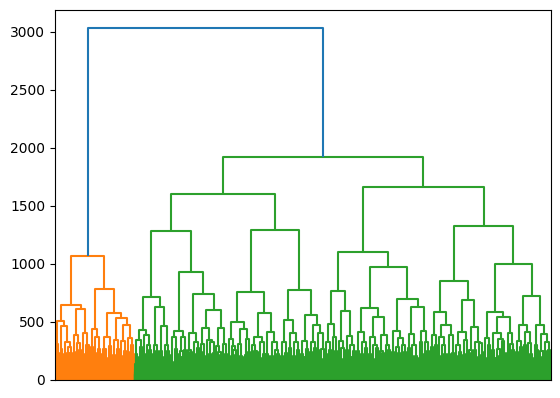

In [43]:
# Calcular la matriz de enlace para el análisis de clustering jerárquico y crear un dendrograma.
linkage_matrix = sch.linkage(df_std_distance, method='ward')

# Crear el dendrograma utilizando la matriz de enlace calculada
dendrogram = sch.dendrogram(linkage_matrix, labels=datos_selected.index, leaf_font_size=9, leaf_rotation=90)

# Configuración del gráfico
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

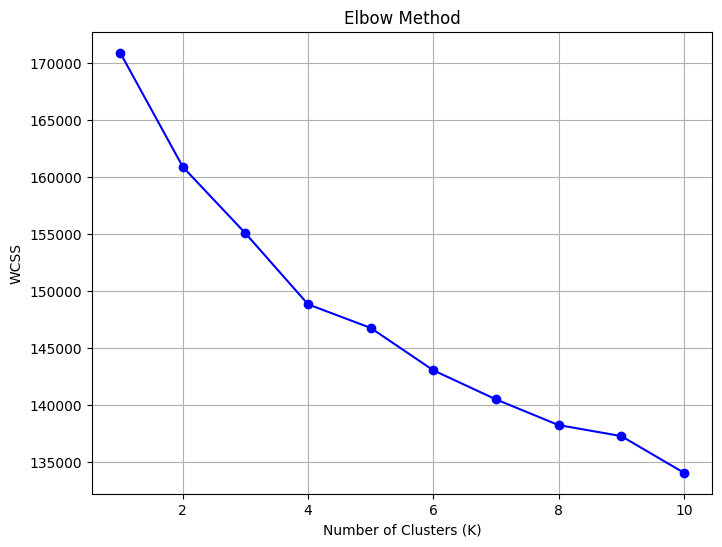

In [44]:
"""
El método del codo (Elbow Method) se utiliza para determinar el número óptimo de clústeres (K) en el análisis de clustering.
El método se basa en encontrar el punto donde la disminución de la variación interna dentro de los clústeres (WCSS) se estabiliza.
"""
# Crear una lista para almacenar los valores de WCSS (Within-Cluster Sum of Squares) para diferentes valores de K
wcss = []

# Iterar sobre un rango de valores para K
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_selected)
    wcss.append(kmeans.inertia_)  # Almacenar el valor de WCSS (inercia) para el valor actual de K

# Graficar los valores de WCSS en función del número de clústeres (K) para identificar el punto del "codo".
# El "codo" indica el número óptimo de clústeres, donde la disminución de WCSS se estabiliza.
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

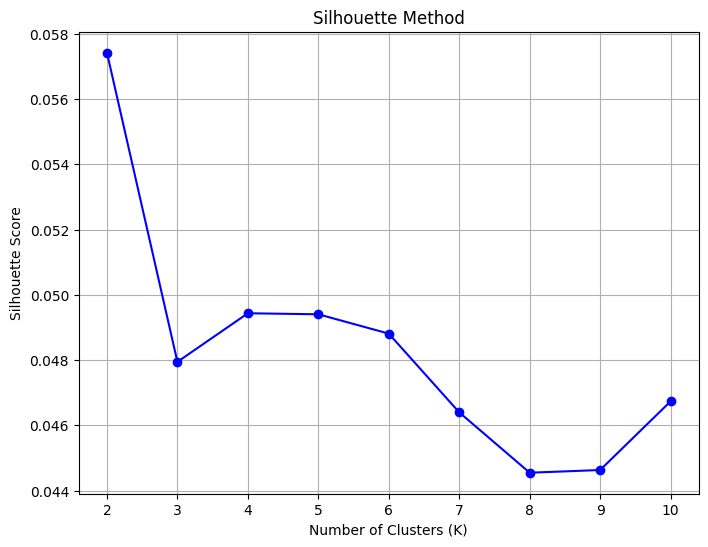

In [45]:
"""
El método de las siluetas se utiliza para evaluar la calidad de la agrupación en el clustering.
El puntaje de silueta mide qué tan cerca están los puntos de datos de su propio clúster en comparación con otros clústeres.
Un puntaje más alto indica una mejor agrupación.
"""

# Crear una lista para almacenar los puntajes de silueta para diferentes valores de K
silhouette_scores = []

# Ejecutar el clustering K-means para un rango de valores de K y calcular el puntaje de silueta para cada K
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_selected)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(datos_selected, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar los puntajes de silueta en función del número de clústeres (K).
# Un puntaje de silueta más alto indica una mejor agrupación.
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

<a id="62"></a> 
## 6.2 Resultados del clustering con k = 4

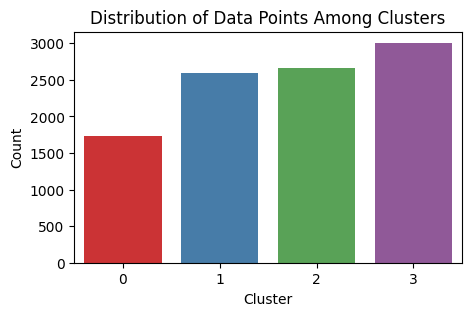

BodyType  Sex  ShowerFreq  SocialActivity  AirTravelFreq  WasteBagSize  \
0       2.0    0         2.0             2.0            2.0           2.0   
1       3.0    0         0.0             2.0            1.0           3.0   
2       2.0    1         1.0             0.0            0.0           0.0   
3       2.0    1         3.0             1.0            1.0           1.0   
4       3.0    0         2.0             2.0            3.0           2.0   

   EnergyEfficiency  GroceryBill_z  DriveDistance_z  WasteBagCount_z  \
0               0.0       0.777025        -0.657677        -0.012360   
1               0.0      -0.828947        -0.730251        -0.514803   
2               1.0      -0.496677         0.159055        -1.519689   
3               1.0      -0.233630        -0.706782        -0.514803   
4               2.0       1.275430         2.320034        -1.519689   

   TVPCHours_z  ClothesNew_z  InternetHours_z  RecyclingMetal  \
0    -0.723218      0.060621        -1.496402               1   
1    -0.441767      0.877059        -0.946714               1   
2     0.261863      1.489387        -0.809292               1   
3     1.106218     -1.368146        -0.671870               1   
4    -1.286122     -1.368146        -0.809292               0   

   RecyclingPlastic  RecyclingPaper  RecyclingGlass  CookingWithGrill  \
0                 0               0               0                 0   
1                 0               0               0                 0   
2                 0               0               0                 0   
3                 1               1               1                 1   
4                 0               1               0                 0   

   CookingWithOven  CookingWithMicrowave  CookingWithAirfryer  \
0                1                     0                    0   
1                0                     1                    0   
2                1                     1                    0   
3                0                     1                    1   
4                1                     0                    0   

   CookingWithStove  EnergyHeat_electricity  EnergyHeat_natural gas  \
0                 1                       0                       0   
1                 1                       0                       1   
2                 0                       0                       0   
3                 0                       0                       0   
4                 0                       0                       0   

   EnergyHeat_coal  EnergyHeat_wood  TransportVehicleType_walk/bicycle  \
0                1                0                                  0   
1                0                0                                  1   
2                0                1                                  0   
3                0                1                                  1   
4                1                0                                  0   

   TransportVehicleType_public  TransportVehicleType_electric  \
0                            1                              0   
1                            0                              0   
2                            0                              0   
3                            0                              0   
4                            0                              0   

   TransportVehicleType_hybrid  TransportVehicleType_lpg  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   TransportVehicleType_petrol  TransportVehicleType_diesel  Diet_pescatarian  \
0                            0                            0                 1   
1                            0                            0                 0   
2                  

In [46]:
# Inicializar y ajustar el modelo KMeans con 4 clústeres y una semilla aleatoria para reproducibilidad
kmeans = KMeans(n_clusters=4, random_state=seed)
clusters = kmeans.fit_predict(datos_selected)

# Añadir las etiquetas de clúster al DataFrame 'datos' para análisis futuros
datos['cluster'] = clusters
datos_load['cluster'] = clusters

# Visualizamos la distribución de los puntos de datos entre los 4 clústeres
plt.figure(figsize=(5, 3))
sns.countplot(x='cluster', data=datos_load, palette='Set1')
plt.title('Distribution of Data Points Among Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Mostrar las primeras filas del DataFrame con las asignaciones de clúster
datos.head()

Investigación de los resultados: Cálculo de medias y desviaciones estándar por grupo

In [47]:
# Calcular las estadísticas descriptivas por cada grupo (media y desviación estándar)
mean_by_cluster = datos.groupby('cluster').mean()
std_by_cluster = datos.groupby('cluster').std()

# Mostrar las medias y desviaciones estándar
display("Medias por cluster:")
display(mean_by_cluster)
display("\nDesviaciones estándar por cluster:")
display(std_by_cluster)

'Medias por cluster:'

BodyType       Sex  ShowerFreq  SocialActivity  AirTravelFreq  \
cluster                                                                  
0        1.501441  0.482997    1.548703        0.972911       1.454755   
1        2.604938  0.503472    1.498843        0.972608       2.221836   
2        0.391973  0.494374    1.487997        0.976744       2.221305   
3        1.511473  0.509478    1.513801        1.030928       0.312604   

         WasteBagSize  EnergyEfficiency  GroceryBill_z  DriveDistance_z  \
cluster                                                                   
0            1.577522          1.047262       0.044060         1.950695   
1            1.515432          0.996528      -0.034475        -0.399384   
2            1.433233          1.011253       0.003171        -0.399280   
3            1.493183          0.997340       0.001484        -0.427261   

         WasteBagCount_z  TVPCHours_z  ClothesNew_z  InternetHours_z  \
cluster                                                                
0              -0.001935     0.005880     -0.002004        -0.016442   
1              -0.004413    -0.015951      0.011457         0.007393   
2               0.011952    -0.001695     -0.003180        -0.002389   
3              -0.005676     0.011860     -0.005900         0.005232   

         RecyclingMetal  RecyclingPlastic  RecyclingPaper  RecyclingGlass  \
cluster                                                                     
0              0.480115          0.489337        0.480115        0.486455   
1              0.495370          0.513889        0.510417        0.489969   
2              0.520630          0.489872        0.499625        0.504126   
3              0.512803          0.502162        0.495178        0.505820   

         CookingWithGrill  CookingWithOven  CookingWithMicrowave  \
cluster                                                            
0                0.495677         0.513545              0.503746   
1                0.495370         0.505401              0.500772   
2                0.498500         0.510128              0.513503   
3                0.505155         0.495178              0.509478   

         CookingWithAirfryer  CookingWithStove  EnergyHeat_electricity  \
cluster                                                                  
0                   0.495677          0.485303                0.250720   
1                   0.495370          0.513117                0.259259   
2                   0.498500          0.497374                0.261065   
3                   0.505155          0.513136                0.249085   

         EnergyHeat_natural gas  EnergyHeat_coal  EnergyHeat_wood  \
cluster                                                             
0                      0.232277         0.266282         0.250720   
1                      0.243056         0.254630         0.243056   
2                      0.242311         0.249062         0.247562   
3                      0.260392         0.245095         0.245427   

         TransportVehicleType_walk/bicycle  TransportVehicleType_public  \
cluster                                                                   
0                                 0.000000                     0.000000   
1                                 0.402006                     0.403935   
2                                 0.412228                     0.387847   
3                                 0.427669                     0.403392   

         TransportVehicleType_electric  TransportVehicleType_hybrid  \
cluster                                                               
0                             0.208069                     0.187896   
1                             0.035108                     0.038580   
2                             0.039385                     0.040885   
3                             0.037912                     0.035584   

         TransportVehicleType_lpg  TransportVehicleType_petrol  \
clus

'\nDesviaciones estándar por cluster:'

BodyType       Sex  ShowerFreq  SocialActivity  AirTravelFreq  \
cluster                                                                  
0        1.094641  0.499855    1.126291        0.820628       1.063768   
1        0.488958  0.500084    1.119973        0.818791       0.746391   
2        0.488282  0.500062    1.113134        0.822881       0.741539   
3        0.966738  0.499993    1.116795        0.817336       0.463632   

         WasteBagSize  EnergyEfficiency  GroceryBill_z  DriveDistance_z  \
cluster                                                                   
0            1.105017          0.810871       1.009370         0.569765   
1            1.115032          0.812620       0.990289         0.429545   
2            1.127619          0.809341       1.004255         0.444175   
3            1.124281          0.802520       0.998705         0.384239   

         WasteBagCount_z  TVPCHours_z  ClothesNew_z  InternetHours_z  \
cluster                                                                
0               0.996393     0.992699      1.005900         1.002132   
1               1.000336     1.006771      0.999361         0.995893   
2               0.993832     0.999039      1.009086         1.010929   
3               1.007785     0.999666      0.989576         0.993083   

         RecyclingMetal  RecyclingPlastic  RecyclingPaper  RecyclingGlass  \
cluster                                                                     
0              0.499748          0.500030        0.499748        0.499961   
1              0.500075          0.499904        0.499988        0.499996   
2              0.499668          0.499991        0.500094        0.500077   
3              0.499919          0.500078        0.500060        0.500049   

         CookingWithGrill  CookingWithOven  CookingWithMicrowave  \
cluster                                                            
0                0.500125         0.499961              0.500130   
1                0.500075         0.500067              0.500096   
2                0.500092         0.499991              0.499911   
3                0.500057         0.500060              0.499993   

         CookingWithAirfryer  CookingWithStove  EnergyHeat_electricity  \
cluster                                                                  
0                   0.500125          0.499928                0.433553   
1                   0.500075          0.499924                0.438313   
2                   0.500092          0.500087                0.439298   
3                   0.500057          0.499911                0.432555   

         EnergyHeat_natural gas  EnergyHeat_coal  EnergyHeat_wood  \
cluster                                                             
0                      0.422406         0.442141         0.433553   
1                      0.429011         0.435737         0.429011   
2                      0.428562         0.432551         0.431677   
3                      0.438922         0.430215         0.430412   

         TransportVehicleType_walk/bicycle  TransportVehicleType_public  \
cluster                                                                   
0                                 0.000000                     0.000000   
1                                 0.490398                     0.490779   
2                                 0.492328                     0.487351   
3                                 0.494823                     0.490660   

         TransportVehicleType_electric  TransportVehicleType_hybrid  \
cluster                                                               
0                             0.406044                     0.390742   
1                             0.184088                     0.192630   
2                             0.194545                     0.198061   
3                             0.191014                     0.185280   

         TransportVehicleType_lpg  TransportVehicleType_petrol  \
clus

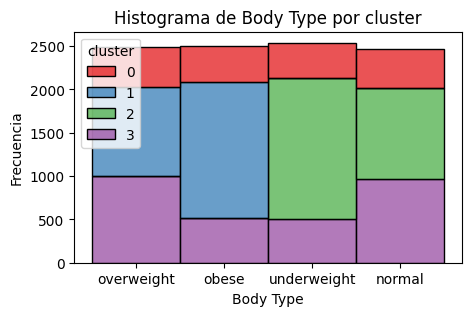

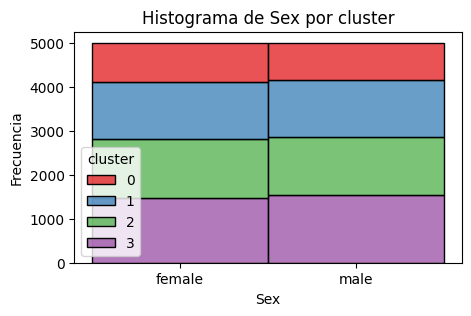

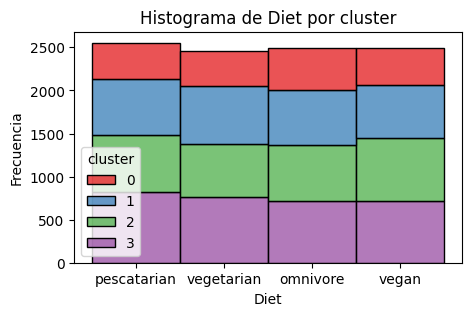

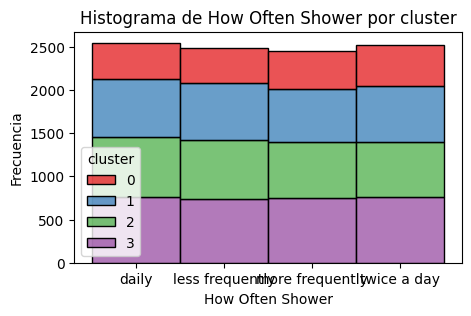

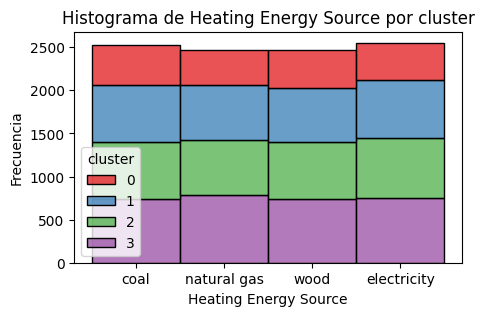

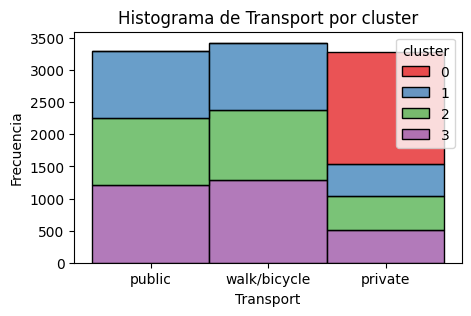

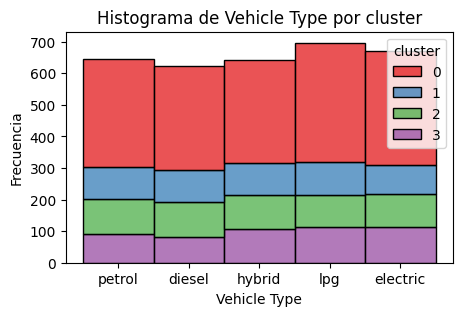

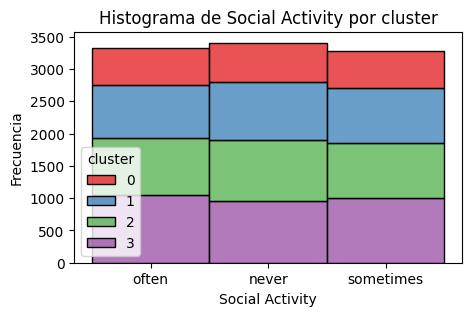

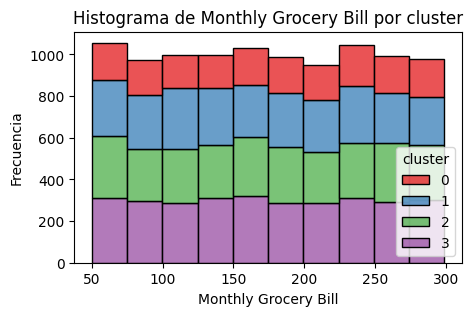

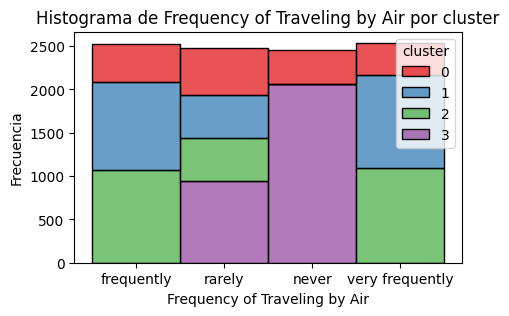

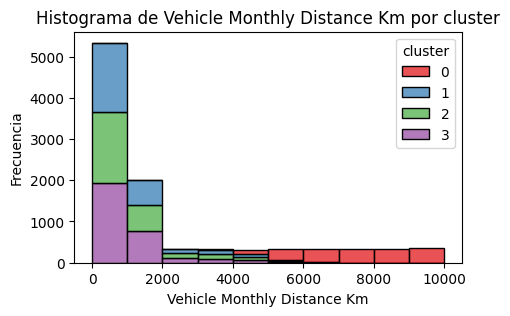

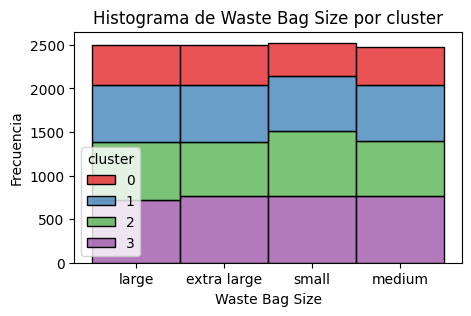

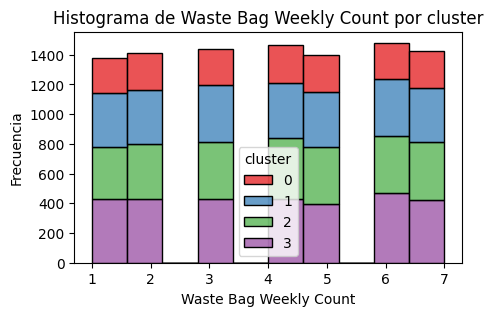

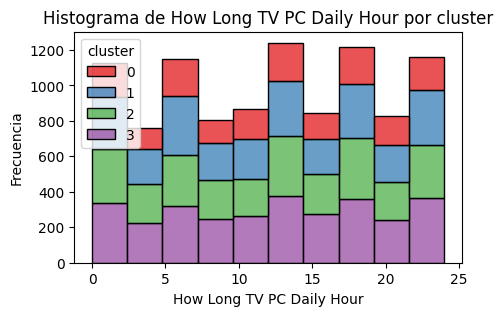

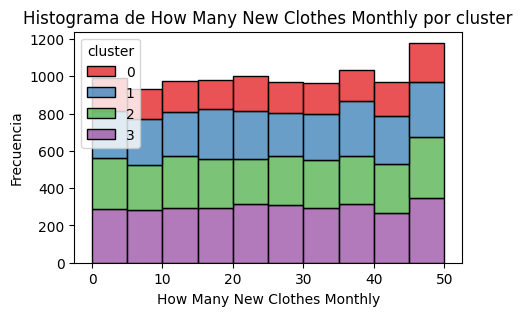

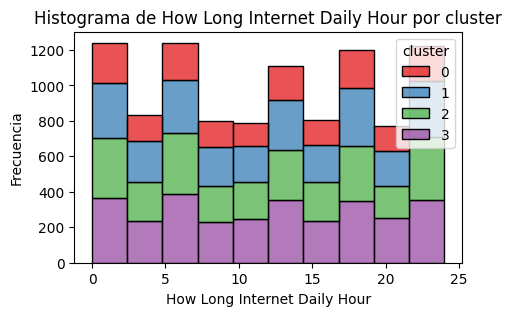

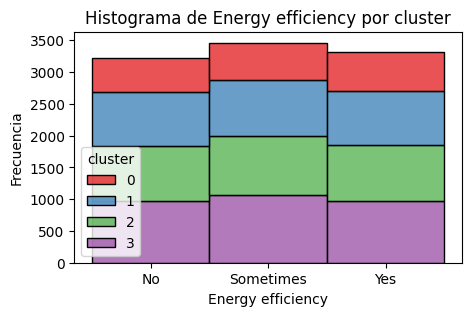

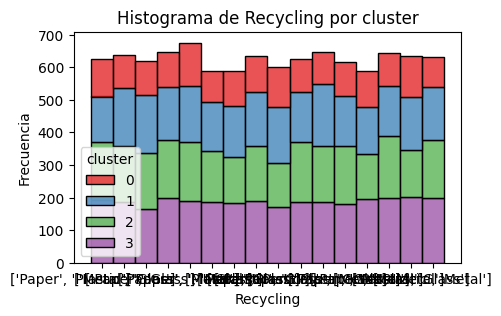

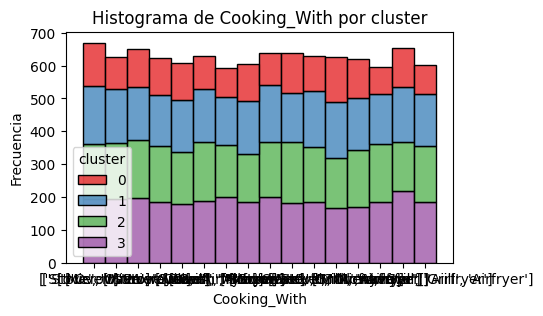

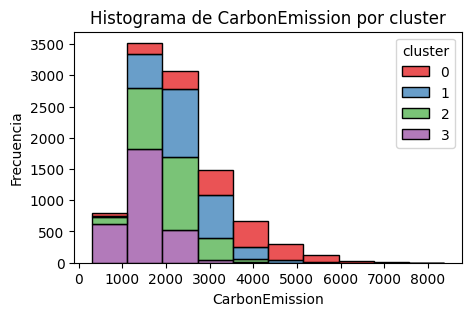

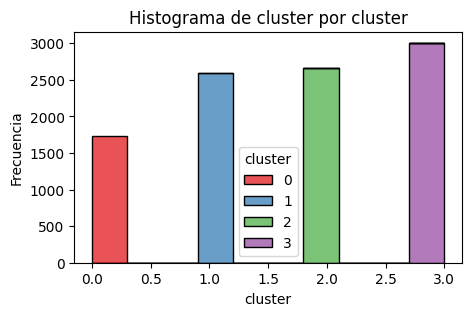

In [48]:
# Seleccionar las columnas a visualizar
variables = datos_load.columns

# Crear un histograma con las frecuencias de la variable, coloreado por clúster
for variable in variables:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=datos_load, x=variable, hue='cluster', multiple='stack', kde=False, palette='Set1', bins=10)
    plt.title(f'Histograma de {variable} por cluster')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.show()

<a id="7"></a> 
# 7. Modelos de predicción con Machine Learning

In [49]:
X = datos[VarExp] # Seleccionar las características explicativas
y = datos[VarObj] # Seleccionar la variable objetivo

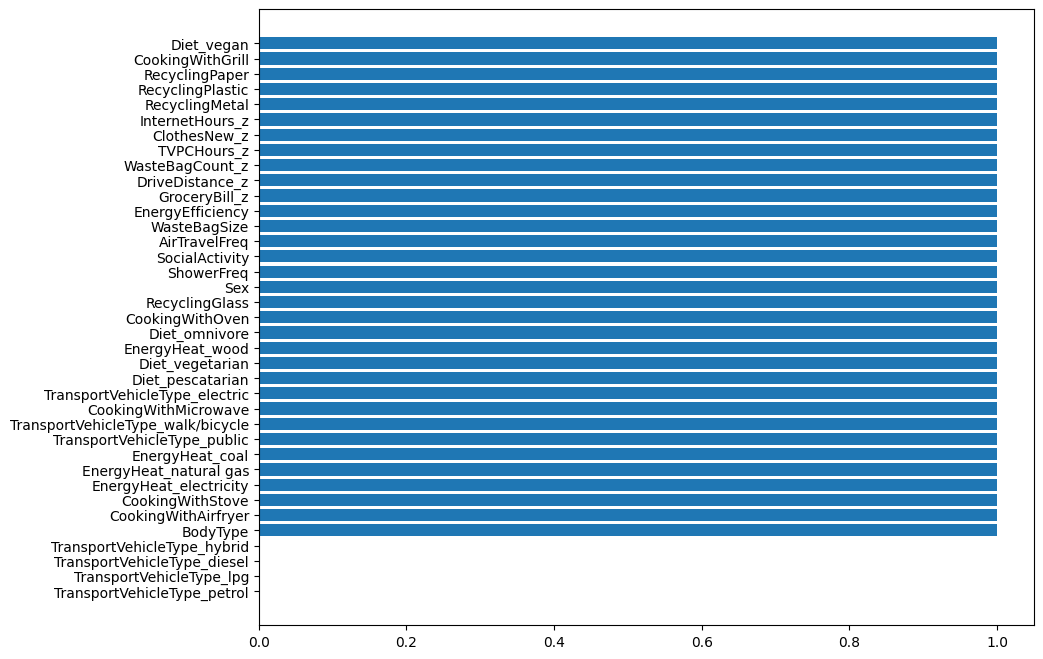

31    TransportVehicleType_petrol
30       TransportVehicleType_lpg
32    TransportVehicleType_diesel
29    TransportVehicleType_hybrid
Name: feature, dtype: object

In [50]:
# Investigación de variables más importantes con K Selector
# Normalizar las características usando MinMaxScaler
scaler = MinMaxScaler()
X_transformed = scaler.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

# Crear el selector K-Best con la función de puntuación chi-cuadrado y seleccionar las 4 mejores características
selector = SelectKBest(score_func=chi2, k=4)
selector.fit(X_transformed,y)

# Crear un DataFrame con los p-valores y las características correspondientes
df_chi2 = pd.DataFrame(zip(selector.pvalues_, X.columns), columns=["pvalor", "feature"]).sort_values("pvalor")

# Graficar los p-valores de las características
plt.figure(figsize=(10, 8))  
plt.barh(y=df_chi2["feature"], width=df_chi2["pvalor"])
plt.show()

# Filtrar las características con p-valor menor a 0.05 y mostrar las características seleccionadas
VarsKSelect = df_chi2[df_chi2['pvalor']<0.05]
VarsKSelect = VarsKSelect['feature']
display(VarsKSelect)

<a id="71"></a> 
## 7.1 Modelos base: LinearRegression, RandomForest y XGBoost

In [51]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [52]:
# Función para evaluar el rendimiento del modelo
def evaluate_model(model, X_test, y_test):
    """
    Evalúa el rendimiento de un modelo usando las métricas MAE, MSE y R^2.
    
    Inputs:
    model: El modelo a evaluar.
    X_test: Las características del conjunto de prueba.
    y_test: Los valores verdaderos del conjunto de prueba.
    
    Outputs:
    mae: Error absoluto medio.
    mse: Error cuadrático medio.
    r2: Coeficiente de determinación R^2.
    """

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    """
    print(f"Modelo: {model.__class__.__name__}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R^2: {r2:.4f}")
    print("-" * 30)
    """
    return mae, mse, r2

### 1. Regresión Lineal Múltiple
# Crear el modelo de regresión lineal
linear_model = LinearRegression()
# Entrenar el modelo
linear_model.fit(X_train, y_train)
# Evaluar el modelo
evaluate_model(linear_model, X_test, y_test)

### 2. Random Forest
# Crear el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
# Entrenar el modelo
rf_model.fit(X_train, y_train)
# Evaluar el modelo
evaluate_model(rf_model, X_test, y_test)

### 3. XGBoost
# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=seed)
# Entrenar el modelo
xgb_model.fit(X_train, y_train)
# Evaluar el modelo
evaluate_model(xgb_model, X_test, y_test)

### Comparación de los modelos
linear_mae, linear_mse, linear_r2 = evaluate_model(linear_model, X_test, y_test)
rf_mae, rf_mse, rf_r2 = evaluate_model(rf_model, X_test, y_test)
xgb_mae, xgb_mse, xgb_r2 = evaluate_model(xgb_model, X_test, y_test)

# Resumen de los resultados
resultados = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest', 'XGBoost'],
    'MAE': [linear_mae, rf_mae, xgb_mae],
    'MSE': [linear_mse, rf_mse, xgb_mse],
    'R^2': [linear_r2, rf_r2, xgb_r2]
})

print("Comparación de Modelos")
display(resultados)

Comparación de Modelos


Modelo         MAE           MSE       R^2
0  Regresión Lineal  210.161687  83006.109239  0.918714
1     Random Forest  202.184025  69587.670517  0.931855
2           XGBoost  118.743139  26122.756721  0.974419

In [53]:
# Investigar el sobreajuste
# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE) para el conjunto de entrenamiento
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Imprimir los resultados del MSE para ambos conjuntos
print(f"Error de Entrenamiento (MSE): {train_mse}")
print(f"Error de Prueba (MSE): {test_mse}")

Error de Entrenamiento (MSE): 83934.93805871582
Error de Prueba (MSE): 83006.10923925781


<a id="711"></a> 
### 7.1.1 Modelo LinearRegression

In [54]:
# Añadir constante a las variables independientes (intercepto)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Resumen completo del modelo (coeficientes, p-valores, R², etc.)
print(results.summary())

# Predecir sobre los datos de prueba
y_pred = results.predict(X_test_sm)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

                            OLS Regression Results                            
Dep. Variable:         CarbonEmission   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     2747.
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        13:58:49   Log-Likelihood:                -56703.
No. Observations:                8000   AIC:                         1.135e+05
Df Residuals:                    7966   BIC:                         1.137e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

<a id="712"></a> 
### 7.1.2 Modelo RandomForest

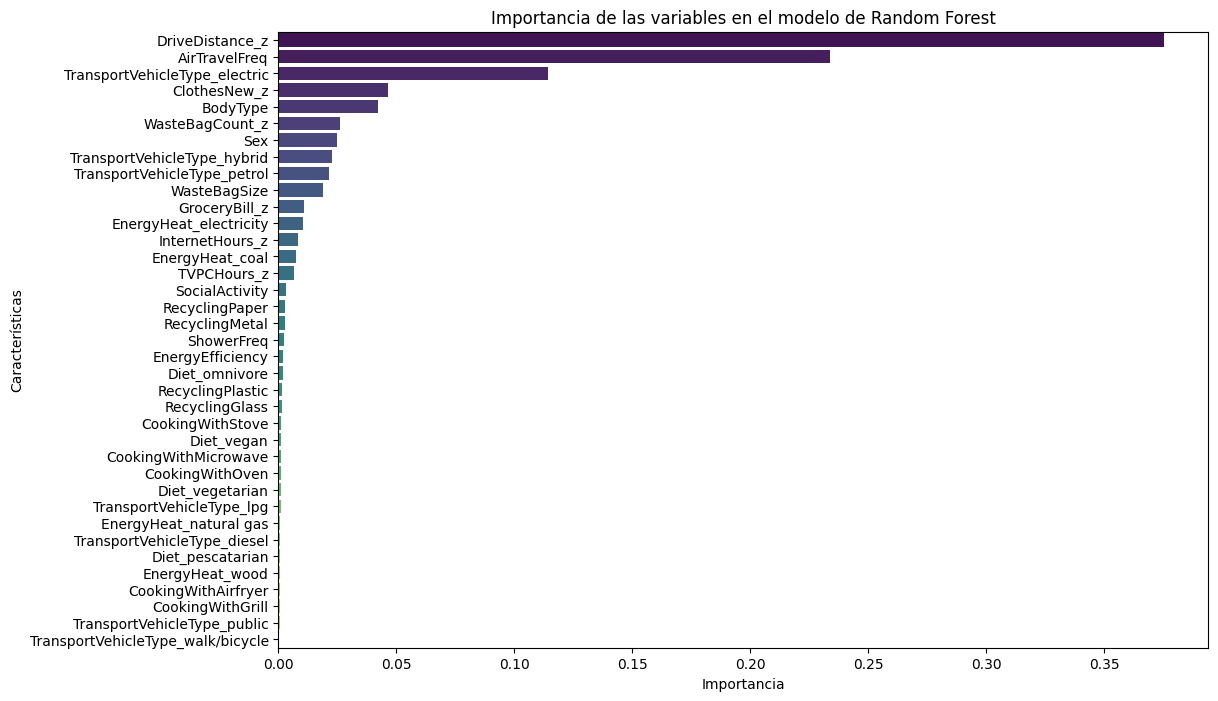

In [55]:
# Obtener las importancias de las variables
importances = rf_model.feature_importances_

# Crear un DataFrame con las importancias de las variables
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las importancias de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importancia de las variables en el modelo de Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

<a id="713"></a> 
### 7.1.3 Modelo XGBoost

In [56]:
# Crear el modelo XGBRegressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring=make_scorer(mean_squared_error, greater_is_better=False),
                           cv=5,
                           verbose=0,
                           n_jobs=-1)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mejores parámetros encontrados:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Mean Squared Error: 15604.975343731325
R^2 Score: 0.9847184419631958


In [57]:
# Evaluar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

MAE: 92.33867385864258
Mean Squared Error: 15604.975343731325
R^2 Score: 0.9847184419631958


In [58]:
# Comprobar el sobreajuste
# Predecir sobre los datos de prueba y entrenamiento
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calcular errores
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Error de Entrenamiento (MSE): {train_mse}")
print(f"Error de Prueba (MSE): {test_mse}")

Error de Entrenamiento (MSE): 9665.952624541022
Error de Prueba (MSE): 15604.975343731325


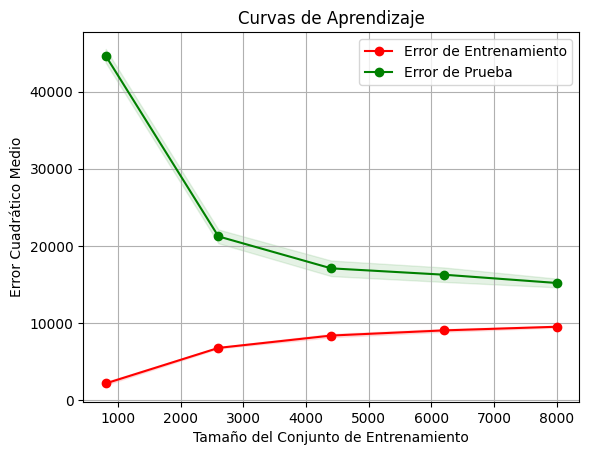

In [59]:
# Graficar la curva de aprendizaje
# Calcular el tamaño del conjunto de entrenamiento, los puntajes de entrenamiento y prueba
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calcular el promedio y desviación estándar
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Configurar la gráfica
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Error de Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Error de Prueba')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.title('Curvas de Aprendizaje')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error Cuadrático Medio')
plt.legend(loc='best')
plt.grid()
plt.show()

<a id="72"></a> 
## 7.2 Productivizar el modelo

In [60]:
# Guardar el modelo predictivo entrenado en un archivo
joblib.dump(best_model, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

In [61]:
# Guardar el modelo clustering entrenado en un archivo
joblib.dump(kmeans, 'modelo_clustering_entrenado.pkl')

['modelo_clustering_entrenado.pkl']